In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/borsa_study

Mounted at /content/gdrive
/content/gdrive/MyDrive/borsa_study


In [2]:
!pip install yfinance
import yfinance as yf
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
SYMBOL = "SUMAS.IS"
START_YEAR = 2018
END_YEAR = 2022
df_symbol = yf.download(SYMBOL, period="max")

[*********************100%***********************]  1 of 1 completed


In [4]:
!pip install mplfinance
!pip install ta
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from datetime import datetime
import numpy as np
from matplotlib import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import plotly.express as px
from mplfinance.original_flavor import candlestick_ohlc
import ta
from matplotlib.pylab import date2num
%matplotlib inline
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70 kB 7.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29104 sha256=8d7d19f2ef9b290466c80ef95aef49beb527eacf954e9f507ecf28e622faa47a
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta


In [5]:
df_symbol.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-09-13,76.900002,76.900002,76.0,76.0,76.0,5155
2022-09-14,74.900002,74.900002,72.0,72.0,72.0,2832


In [6]:
def OHLC_resample(df, freq):
  sample = df.copy()
  d = pd.DataFrame(index=sample.resample(freq).last().dropna().index)
  d['Open'] = sample.resample(freq).first().dropna().Open
  d["High"] = sample.resample(freq).max().dropna().High
  d["Low"] = sample.resample(freq).min().dropna().Low
  d["Close"] = sample.resample(freq).last().dropna().Close
  return d

In [7]:
#df = OHLC_resample(df_btc,freq='15min')
df = df_symbol.copy()
df['Vol_change'] = df['Volume'].pct_change()
df = df.drop(columns=['Adj Close', 'Volume'], axis=1)
df = df.dropna()
df.head()

,Open,High,Low,Close,Vol_change
Date,,,,,
2018-02-12,10.00,10.00,10.00,10.00,7.073171
2018-02-13,8.50,8.50,8.00,8.00,-0.750755
2018-02-14,7.90,7.90,7.70,7.70,-0.557576
2018-02-15,7.40,7.40,7.40,7.40,-0.479452
2018-02-16,7.35,7.35,7.35,7.35,12.210526


In [8]:
def downcast(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    df[float_cols] = df[float_cols].astype(np.float32)
    return df

#df = downcast(df)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1160 entries, 2018-02-12 to 2022-09-14
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        1160 non-null   float64
 1   High        1160 non-null   float64
 2   Low         1160 non-null   float64
 3   Close       1160 non-null   float64
 4   Vol_change  1160 non-null   float64
dtypes: float64(5)
memory usage: 54.4 KB
None


Text(0.5, 1.0, 'SUMAS.IS 1 week Movement')

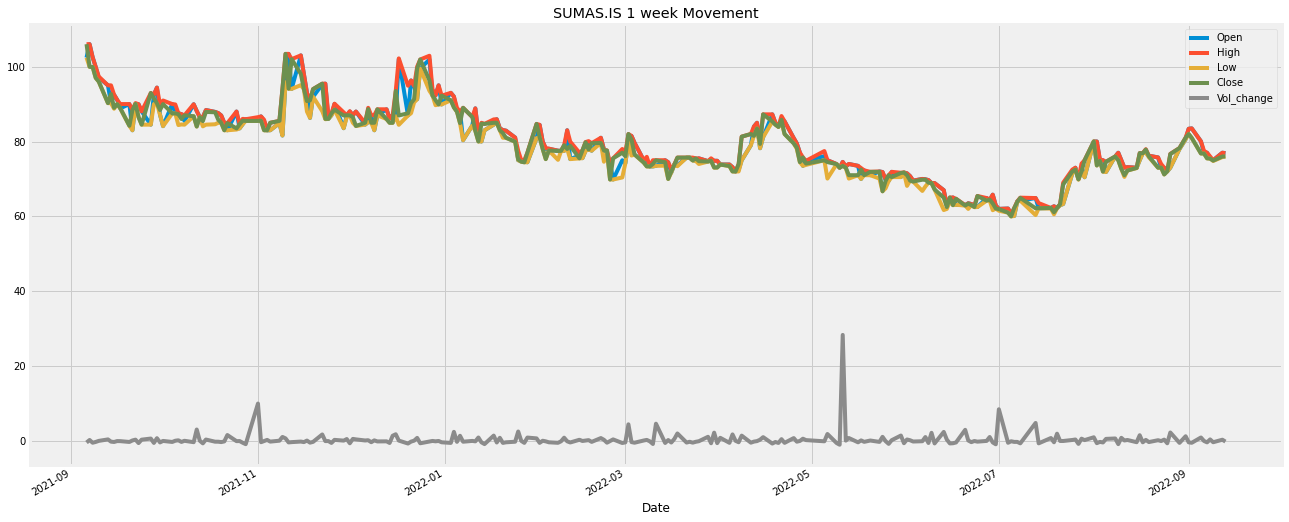

In [9]:
df.loc['2021-09-06':'2022-09-13'].plot(figsize=(20,9))
plt.title('%s 1 week Movement' % SYMBOL)

Text(0.5, 1.0, 'SUMAS.IS movemenet')

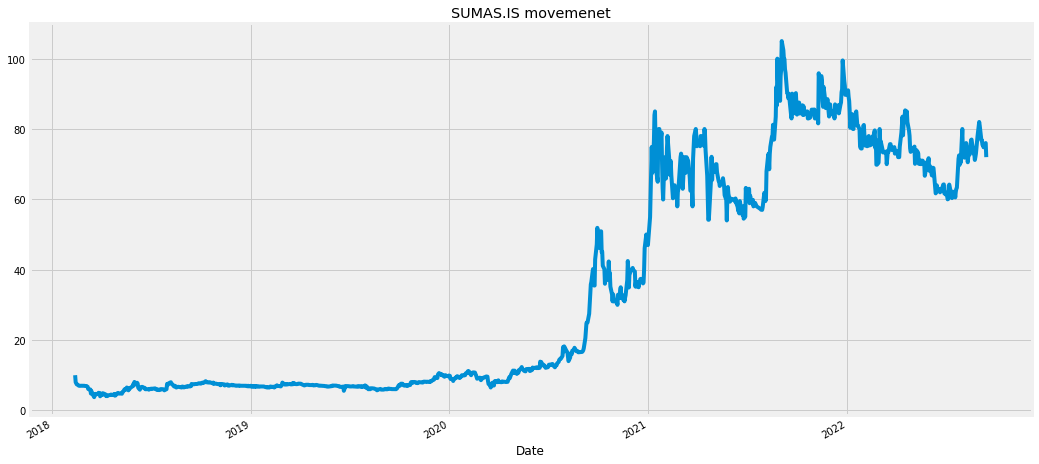

In [10]:
plt.figure(figsize=(16,8))
df.Low.plot()
plt.title('%s movemenet' % SYMBOL)

In [11]:
def bollinger_band(df):
    
    df1 = df.Close.to_frame()
    df["ma7"] = df1.iloc[:,0].rolling(7).mean()       # 7 days moving average
    df['ma30'] = df1.iloc[:,0].rolling(30).mean()      # 30 days moving average
    df1["std7"] = df1.iloc[:,0].rolling(7).std()       # 7 days standard deviation
    df1["std30"] = df1.iloc[:,0].rolling(30).std()       # 30 days standard deviation
    
    df["upper_band7"] = df.ma7 + (df1.std7 * 2) 
    df["lower_band7"] = df.ma7 - (df1.std7 * 2) 
    df["upper_band30"] = df.ma30 + (df1.std30 * 2) 
    df["lower_band30"] = df.ma30 - (df1.std30 * 2) 
    return df

In [12]:
df = bollinger_band(df)
df.head()

,Open,High,Low,Close,Vol_change,ma7,ma30,upper_band7,lower_band7,upper_band30,lower_band30
Date,,,,,,,,,,,
2018-02-12,10.00,10.00,10.00,10.00,7.073171,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-13,8.50,8.50,8.00,8.00,-0.750755,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-14,7.90,7.90,7.70,7.70,-0.557576,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-15,7.40,7.40,7.40,7.40,-0.479452,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-16,7.35,7.35,7.35,7.35,12.210526,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
def macd(df,
         fast,
         slow,
         signal):
    
    df1 = df.Close.to_frame()
    df["ema_fast"] = df1.iloc[:,0].ewm(span=fast,min_periods=fast).mean()   #12 days
    df["ema_slow"] = df1.iloc[:,0].ewm(span=slow,min_periods=slow).mean()   #26 days
    df["macd"] = df.ema_fast - df.ema_slow
    df["signal"] = df["macd"].ewm(span=signal,min_periods=signal).mean()   #9 days
    
    return df
df = macd(df,12, 26, 9)

In [14]:
from ta.momentum import AwesomeOscillatorIndicator,KAMAIndicator, ROCIndicator,RSIIndicator,StochRSIIndicator, TSIIndicator, WilliamsRIndicator

In [15]:
sample = AwesomeOscillatorIndicator(df.High, df.Low, 5, 34, False)
df['AOI'] = sample.awesome_oscillator()
df.AOI.describe()

count    1127.000000
mean        0.908415
std         5.468542
min       -10.464707
25%        -0.689191
50%        -0.009323
75%         1.188823
max        31.123677
Name: AOI, dtype: float64

In [16]:
sample = KAMAIndicator(df.Close, 10, 10, 30, False)   #10 days 
df['KAMA_FAST'] = sample.kama()
sample2 = KAMAIndicator(df.Close, 10, 50, 30 , False)   # 50 days
df['KAMA_SLOW'] = sample2.kama()

In [17]:
sample = ROCIndicator(df.Close, 12, False)  #12*27 =324 12days  
df['ROC'] = sample.roc()
df['ROC'].describe()   

count    1148.000000
mean        3.779519
std        18.207926
min       -33.628321
25%        -5.143376
50%         0.000000
75%         8.493959
max       149.604511
Name: ROC, dtype: float64

In [18]:
sample = RSIIndicator(df.Close, 14, False)  # 14days relative strength index 
df['RSI'] = sample.rsi()
df['RSI'].describe()   # 0-100

count    1147.000000
mean       51.279901
std        12.755294
min         0.432934
25%        43.266723
50%        49.441072
75%        59.378681
max        89.871900
Name: RSI, dtype: float64

In [19]:
sample = StochRSIIndicator(df.Close, 14,3,3, False)  #window 14days , smooth_window 3days
df['STOCH_RSI'] = sample.stochrsi()
df['STOCH_RSI3'] = sample.stochrsi_k()
sample2 = StochRSIIndicator(df.Close, 14, 10, 10, False)
df['STOCH_RSI10'] = sample2.stochrsi_k()

In [20]:
sample2 = TSIIndicator(df.Close, 2,1, False)  
df['TSI_FAST'] = sample2.tsi()
sample = TSIIndicator(df.Close, 25,13, False)  
df['TSI_SLOW'] = sample.tsi()
df['TSI_FAST'].describe(), df['TSI_SLOW'].describe()  #-100/100

(count    1158.000000
 mean       -5.197373
 std        72.344716
 min      -100.000000
 25%       -78.392323
 50%       -10.429892
 75%        66.592805
 max        99.972318
 Name: TSI_FAST, dtype: float64, count    1123.000000
 mean        3.691063
 std        20.668956
 min       -68.750229
 25%       -11.022225
 50%         0.546116
 75%        18.278988
 max        64.857892
 Name: TSI_SLOW, dtype: float64)

In [21]:
sample2 = WilliamsRIndicator(df.High, df.Low, df.Close, 14, False)  #14days
df['WRI_FAST'] = sample2.williams_r()
df['WRI_FAST'].describe()    #100-0

count    1147.000000
mean      -51.753623
std        30.481514
min      -100.000000
25%       -75.905795
50%       -54.545425
75%       -27.649870
max        -0.000000
Name: WRI_FAST, dtype: float64

In [22]:
from ta.volatility import AverageTrueRange, DonchianChannel

In [23]:
sample2 = AverageTrueRange(df.High, df.Low, df.Close, 1, False)  #14days
df['ATR2'] = sample2.average_true_range()
sample = AverageTrueRange(df.High, df.Low, df.Close, 14, False)  #14days
df['ATR'] = sample.average_true_range()
df['ATR2'].describe(), df['ATR'].describe()   #1-17

(count    1160.000000
 mean        1.616414
 std         2.227779
 min         0.000000
 25%         0.140000
 50%         0.500000
 75%         2.400002
 max        17.750000
 Name: ATR2, dtype: float64, count    1160.000000
 mean        1.592928
 std         1.684535
 min         0.000000
 25%         0.218572
 50%         0.474666
 75%         2.849155
 max         5.962150
 Name: ATR, dtype: float64)

In [24]:
sample = DonchianChannel(df.High, df.Low, df.Close, 20,0, False)  #window 20 days
df['DC_HB'] = sample.donchian_channel_hband()   # DC High Band
df['DC_LB'] = sample.donchian_channel_lband()   # DC Low Band
df['DC_MB'] = sample.donchian_channel_mband()   # DC Middle Band
df.sample(2)

,Open,High,Low,Close,Vol_change,ma7,ma30,upper_band7,lower_band7,upper_band30,lower_band30,ema_fast,ema_slow,macd,signal,AOI,KAMA_FAST,KAMA_SLOW,ROC,RSI,STOCH_RSI,STOCH_RSI3,STOCH_RSI10,TSI_FAST,TSI_SLOW,WRI_FAST,ATR2,ATR,DC_HB,DC_LB,DC_MB
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-12-07,7.09,7.09,7.06,7.06,-0.597796,7.124286,7.310333,7.238512,7.010060,7.650860,6.969807,7.158987,7.275271,-0.116284,-0.116228,-0.297647,7.052223,6.842639,-0.141446,40.418806,0.529869,0.640379,0.675981,-78.051685,-16.658684,-88.235311,0.04,0.181271,7.51,7.0,7.255
2019-02-28,8.04,8.04,7.90,7.90,-0.187302,7.261429,6.870333,8.246479,6.276378,7.552126,6.188541,7.213484,7.020095,0.193389,0.070688,0.441235,6.992745,6.856734,17.910453,71.705926,0.876958,0.942986,0.829198,39.341524,24.203428,-9.090901,0.14,0.192178,8.04,6.5,7.270


In [25]:
from ta.trend import AroonIndicator, ADXIndicator

In [26]:
sample = AroonIndicator(df.Close, 25, False)  #25days
df['AI_D'] = sample.aroon_down()
df['AI_I'] = sample.aroon_indicator()
df['AI_U'] = sample.aroon_up()
df.sample(2)

,Open,High,Low,Close,Vol_change,ma7,ma30,upper_band7,lower_band7,upper_band30,lower_band30,ema_fast,ema_slow,macd,signal,AOI,KAMA_FAST,KAMA_SLOW,ROC,RSI,STOCH_RSI,STOCH_RSI3,STOCH_RSI10,TSI_FAST,TSI_SLOW,WRI_FAST,ATR2,ATR,DC_HB,DC_LB,DC_MB,AI_D,AI_I,AI_U
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-05,61.950001,61.950001,61.950001,61.950001,-0.547599,51.645714,41.760000,62.924921,40.366506,54.583339,28.936661,48.472895,43.733642,4.739252,2.606731,12.007206,30.985584,15.813266,65.641707,79.697119,1.0,0.949642,0.811254,98.709484,36.897192,-0.000000,5.600002,2.615249,61.950001,35.0,48.475,24.0,76.0,100.0
2021-02-23,65.000000,65.000000,58.000000,59.700001,0.555517,64.028572,71.371666,70.178600,57.878543,84.598121,58.145212,65.655211,66.865461,-1.210250,0.612717,-8.495588,43.988414,21.826113,-23.461537,41.036128,0.0,0.013666,0.061567,-89.611087,-4.560686,-92.444441,7.000000,5.087931,80.500000,58.0,69.250,100.0,-92.0,8.0


In [27]:
df = downcast(df)  #all datatypes to float32
df.dropna(inplace=True)

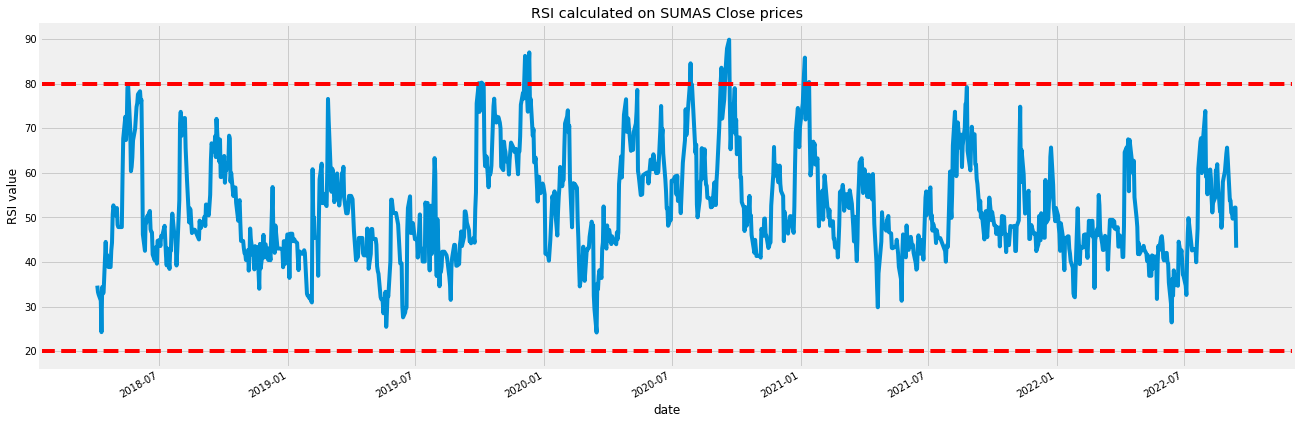

In [28]:
df.RSI.plot(figsize = (20,7))

upper_thresh = 80
lower_thresh = 20

plt.axhline(upper_thresh, 0, 1,c = "red",linestyle='--')
plt.axhline(lower_thresh, 0, 1,c = "red",linestyle='--')

plt.title("RSI calculated on SUMAS Close prices")
plt.ylabel("RSI value")
plt.xlabel("date")
plt.show()

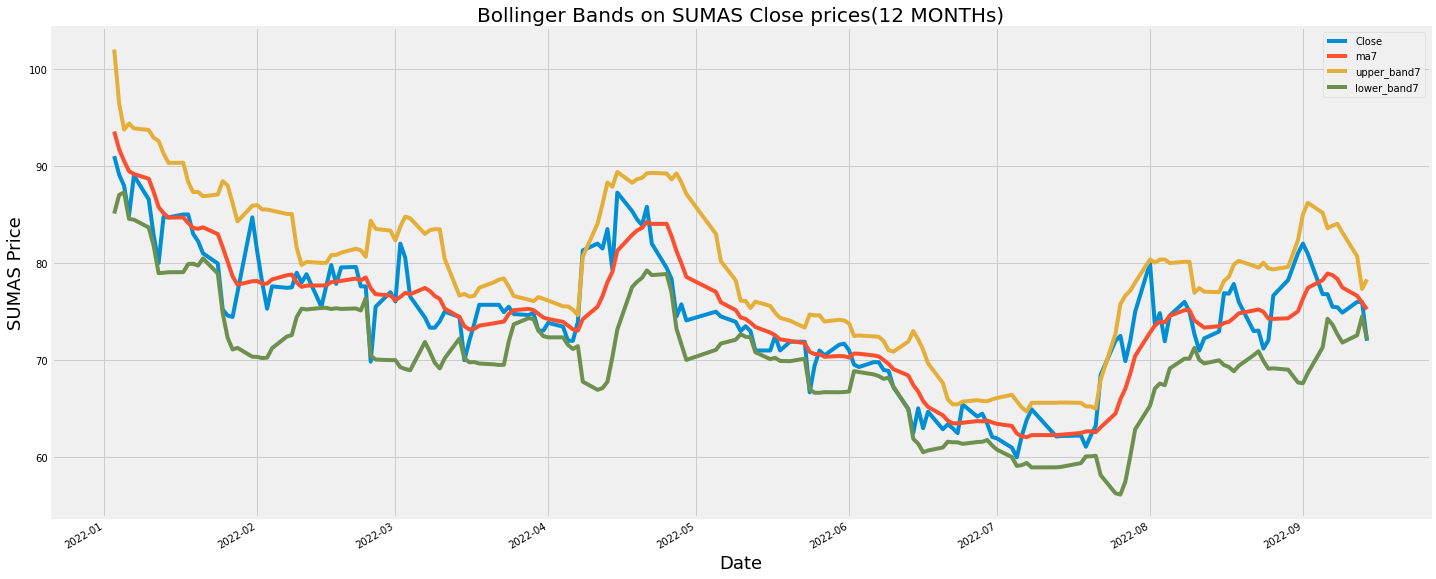

In [29]:
df[['Close','ma7','upper_band7','lower_band7']].loc['2022':].plot(figsize=(22,10))
plt.title("Bollinger Bands on SUMAS Close prices(12 MONTHs)", fontsize=20)
plt.ylabel("SUMAS Price", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.show()

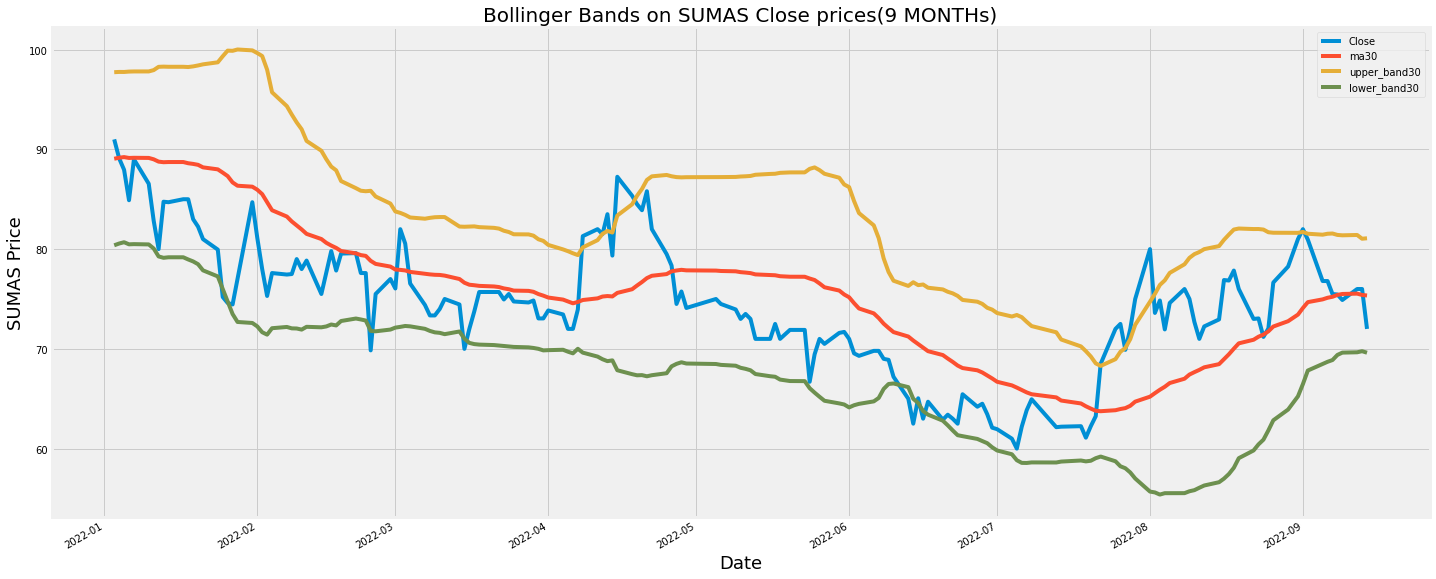

In [30]:
df[['Close','ma30','upper_band30','lower_band30']].loc['2022':].plot(figsize=(22,10))
plt.title("Bollinger Bands on SUMAS Close prices(9 MONTHs)", fontsize=20)
plt.ylabel("SUMAS Price", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.show()

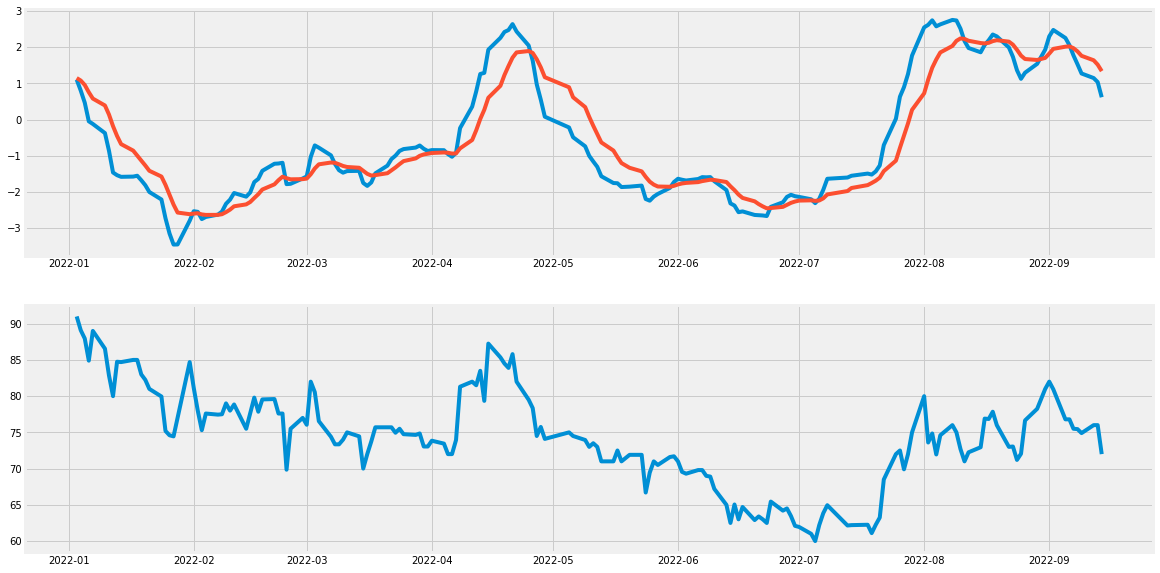

In [31]:
fig = plt.figure(figsize = (18,10))
ax1, ax2 = fig.subplots(2, 1)
ax1.plot(df.loc['2022':][['macd','signal']])
ax2.plot(df.Close.loc['2022':])

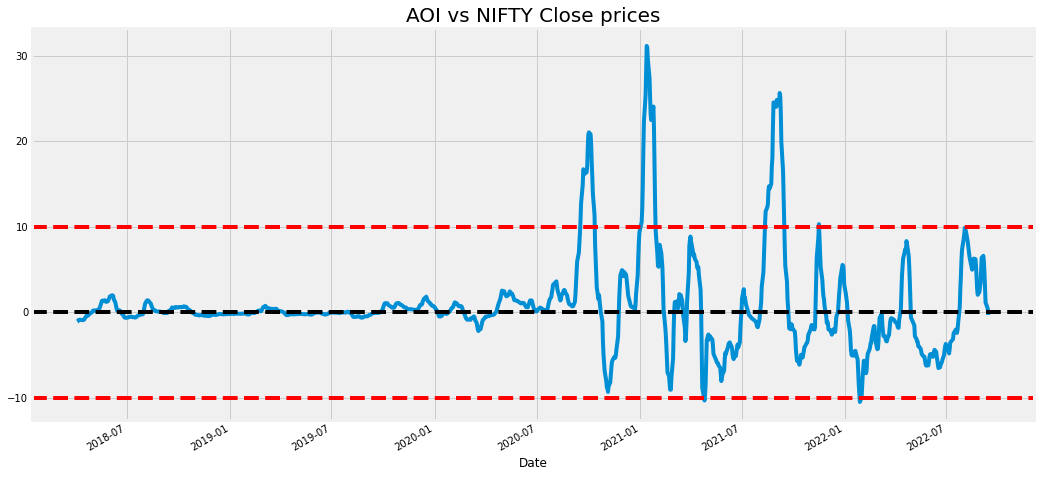

In [32]:
df.AOI.loc['2018':].plot(figsize=(16,8))
upper_thresh = 10
lower_thresh = -10
zero_cross = 0

plt.axhline(upper_thresh, 0, 1,c = "red",linestyle='--')
plt.axhline(lower_thresh, 0, 1,c = "red",linestyle='--')
plt.axhline(zero_cross, 0, 1,c = "black",linestyle='--')
plt.title("AOI vs NIFTY Close prices", fontsize=20)
plt.show()

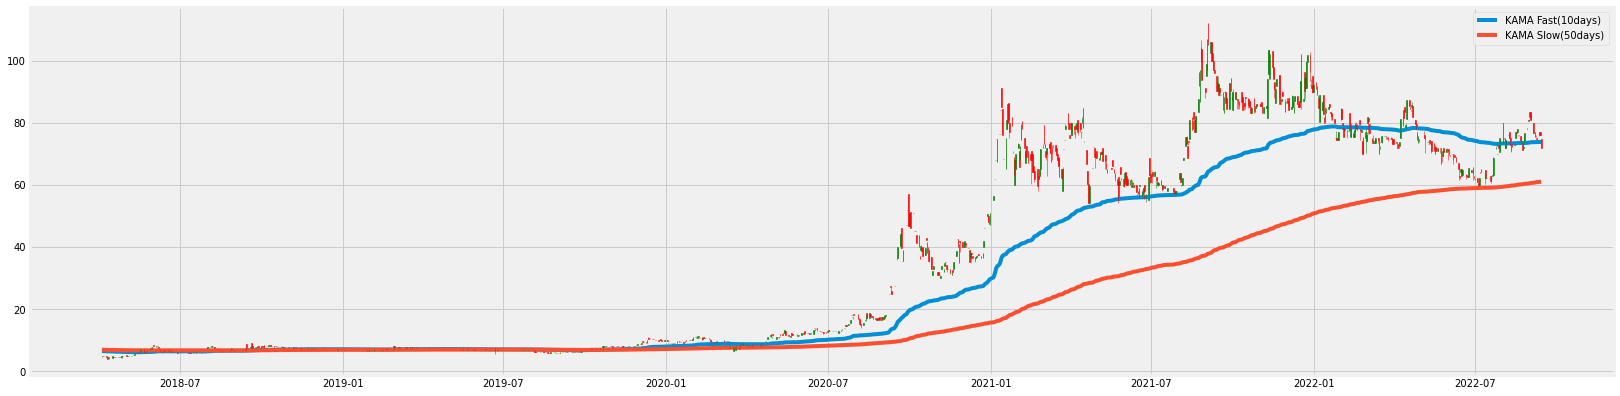

In [33]:
data = df[['Open', 'High','Low','Close','KAMA_FAST','KAMA_SLOW']].loc['2018':].copy()
fig = plt.figure(figsize=(22,16))
ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
ax_candle.xaxis_date()
ohlc = []
for date, row in data.iterrows():
    openp, highp, lowp, closep = row[:4]
    ohlc.append([date2num(date), openp, highp, lowp, closep])
    
ax_candle.plot(data.index, data["KAMA_FAST"], label="KAMA Fast(10days)")
ax_candle.plot(data.index, data["KAMA_SLOW"], label="KAMA Slow(50days)")
candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
ax_candle.legend()

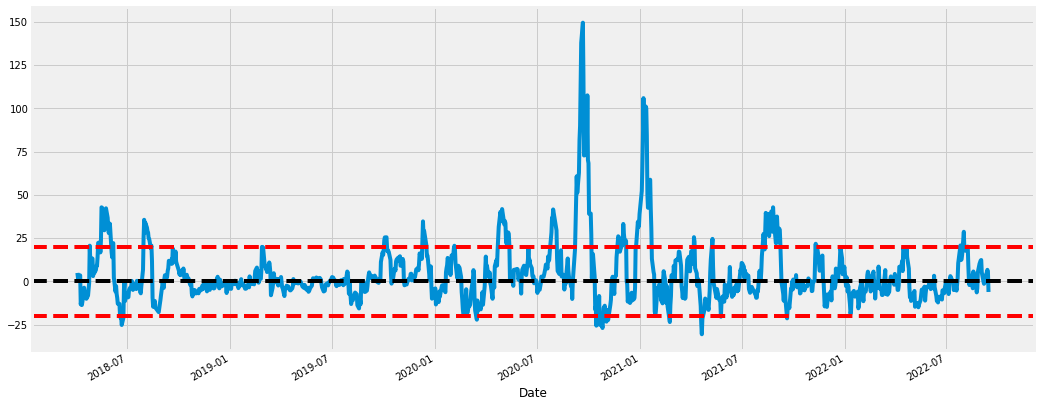

In [34]:
df.ROC.loc['2018':].plot(figsize=(16,7))
upper_thresh = 20
lower_thresh = -20
zero_cross = 0

plt.axhline(upper_thresh, 0, 1,c = "red",linestyle='--')
plt.axhline(lower_thresh, 0, 1,c = "red",linestyle='--')
plt.axhline(zero_cross, 0, 1,c = "black",linestyle='--')
plt.show()

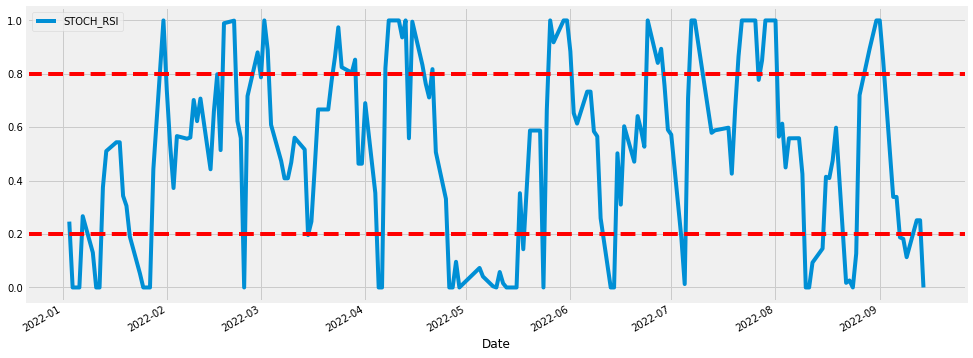

In [35]:
df[['STOCH_RSI']].loc['2022'].plot(figsize=(15,6))
upper_thresh = 0.8
lower_thresh = 0.2


plt.axhline(upper_thresh, 0, 1,c = "red",linestyle='--')
plt.axhline(lower_thresh, 0, 1,c = "red",linestyle='--')
plt.show()

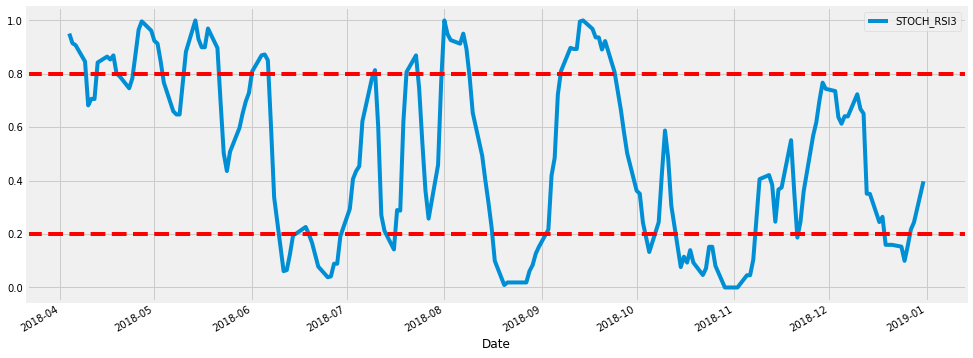

In [36]:
df[['STOCH_RSI3']].loc['2018'].plot(figsize=(15,6))
upper_thresh = 0.8
lower_thresh = 0.2


plt.axhline(upper_thresh, 0, 1,c = "red",linestyle='--')
plt.axhline(lower_thresh, 0, 1,c = "red",linestyle='--')
plt.show()

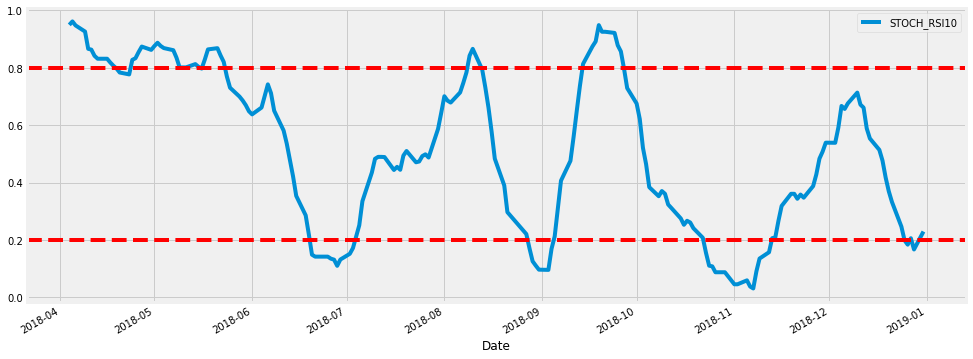

In [37]:
df[['STOCH_RSI10']].loc['2018'].plot(figsize=(15,6))
upper_thresh = 0.8
lower_thresh = 0.2


plt.axhline(upper_thresh, 0, 1,c = "red",linestyle='--')
plt.axhline(lower_thresh, 0, 1,c = "red",linestyle='--')
plt.show()

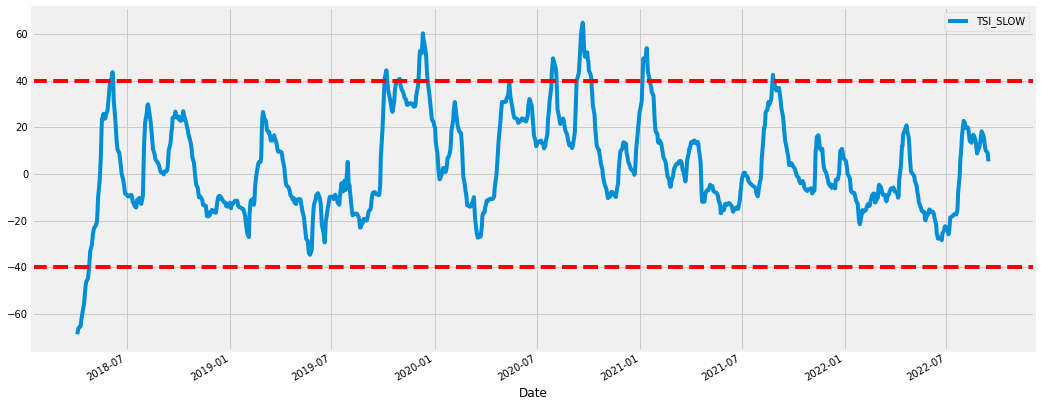

In [38]:
df[['TSI_SLOW']].plot(figsize=(16,7))
upper_thresh = 40
lower_thresh = -40


plt.axhline(upper_thresh, 0, 1,c = "red",linestyle='--')
plt.axhline(lower_thresh, 0, 1,c = "red",linestyle='--')
plt.show()

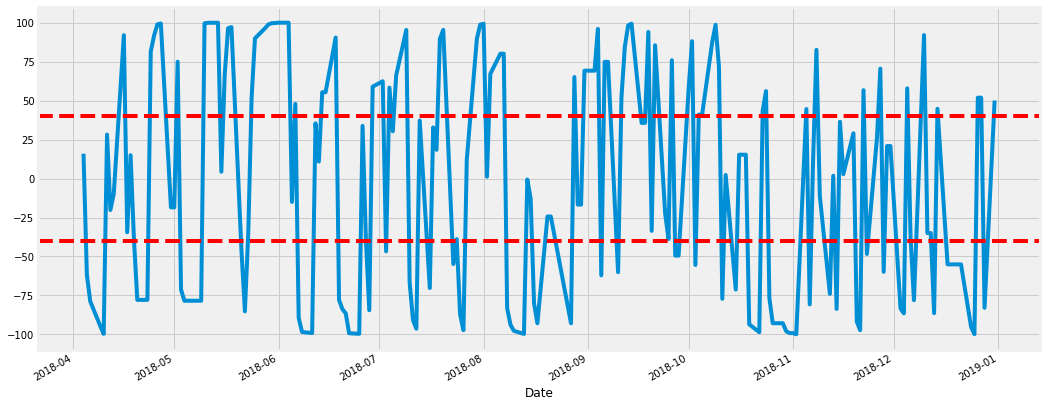

In [39]:
df['TSI_FAST'].loc['2018'].plot(figsize=(16,7))
upper_thresh = 40
lower_thresh = -40


plt.axhline(upper_thresh, 0, 1,c = "red",linestyle='--')
plt.axhline(lower_thresh, 0, 1,c = "red",linestyle='--')
plt.show()

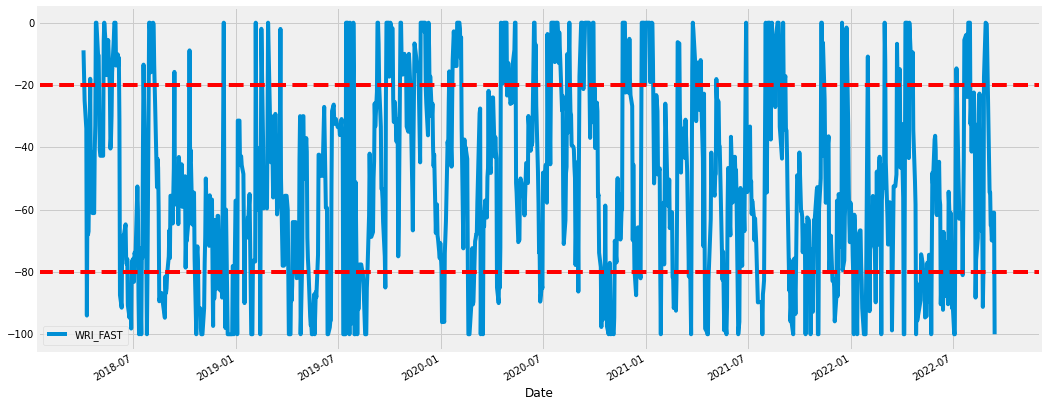

In [40]:
df[['WRI_FAST']].loc['2018':].plot(figsize=(16,7))
upper_thresh = -20
lower_thresh = -80


plt.axhline(upper_thresh, 0, 1,c = "red",linestyle='--')
plt.axhline(lower_thresh, 0, 1,c = "red",linestyle='--')
plt.show()

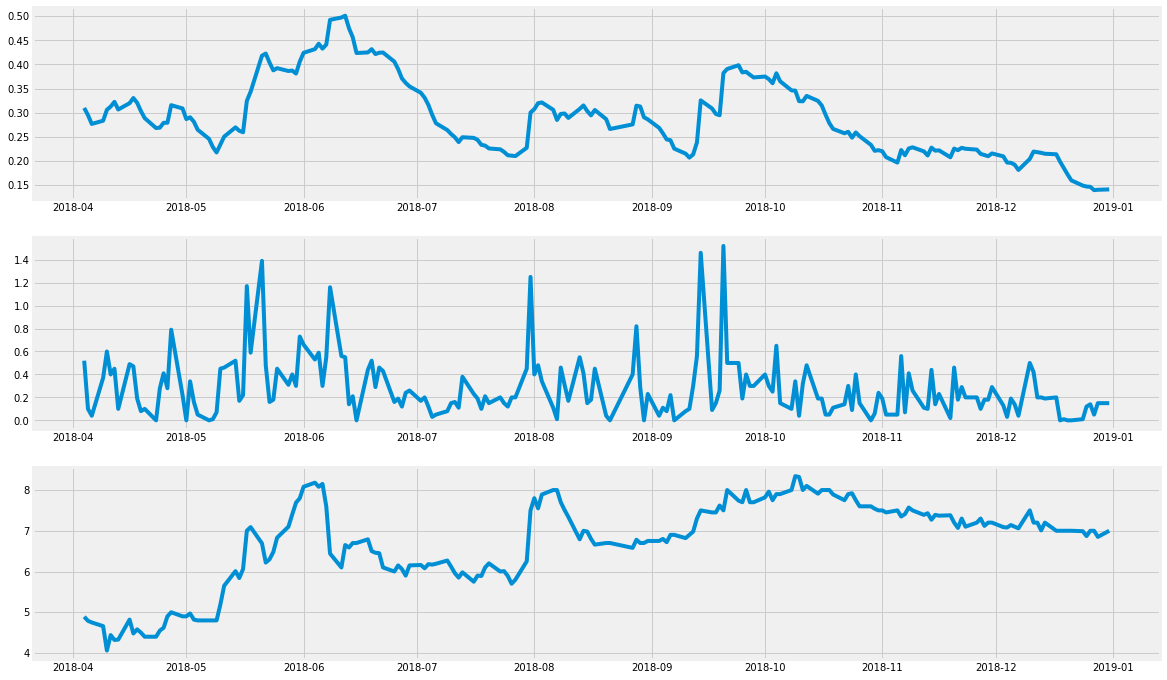

In [41]:
fig = plt.figure(figsize = (18,12))
ax1, ax2, ax3 = fig.subplots(3, 1)
ax1.plot(df.loc['2018'][['ATR']])
ax2.plot(df.loc['2018'][['ATR2']])
ax3.plot(df.Close.loc['2018'])

In [42]:
data = df.loc['2018':].copy()

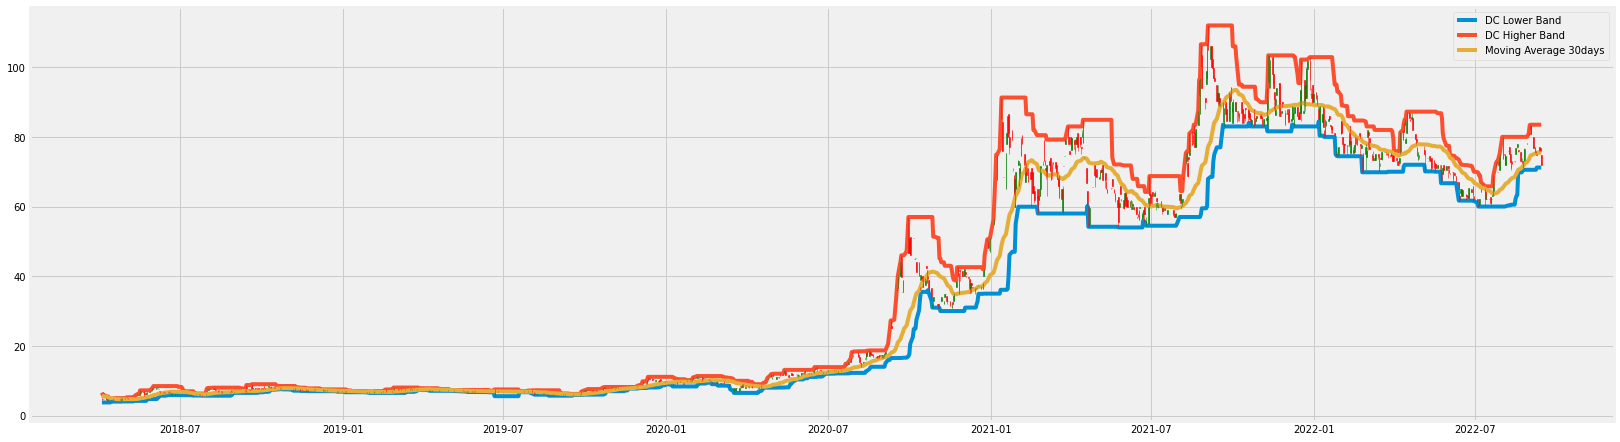

In [43]:
fig = plt.figure(figsize=(22,18))
ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
ax_candle.xaxis_date()
ohlc = []
for date, row in data.iterrows():
    openp, highp, lowp, closep = row[:4]
    ohlc.append([date2num(date), openp, highp, lowp, closep])
    
ax_candle.plot(data.index, data["DC_LB"], label="DC Lower Band")
ax_candle.plot(data.index, data["DC_HB"], label="DC Higher Band")
ax_candle.plot(data.index, data["ma30"], label="Moving Average 30days")
candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
ax_candle.legend()

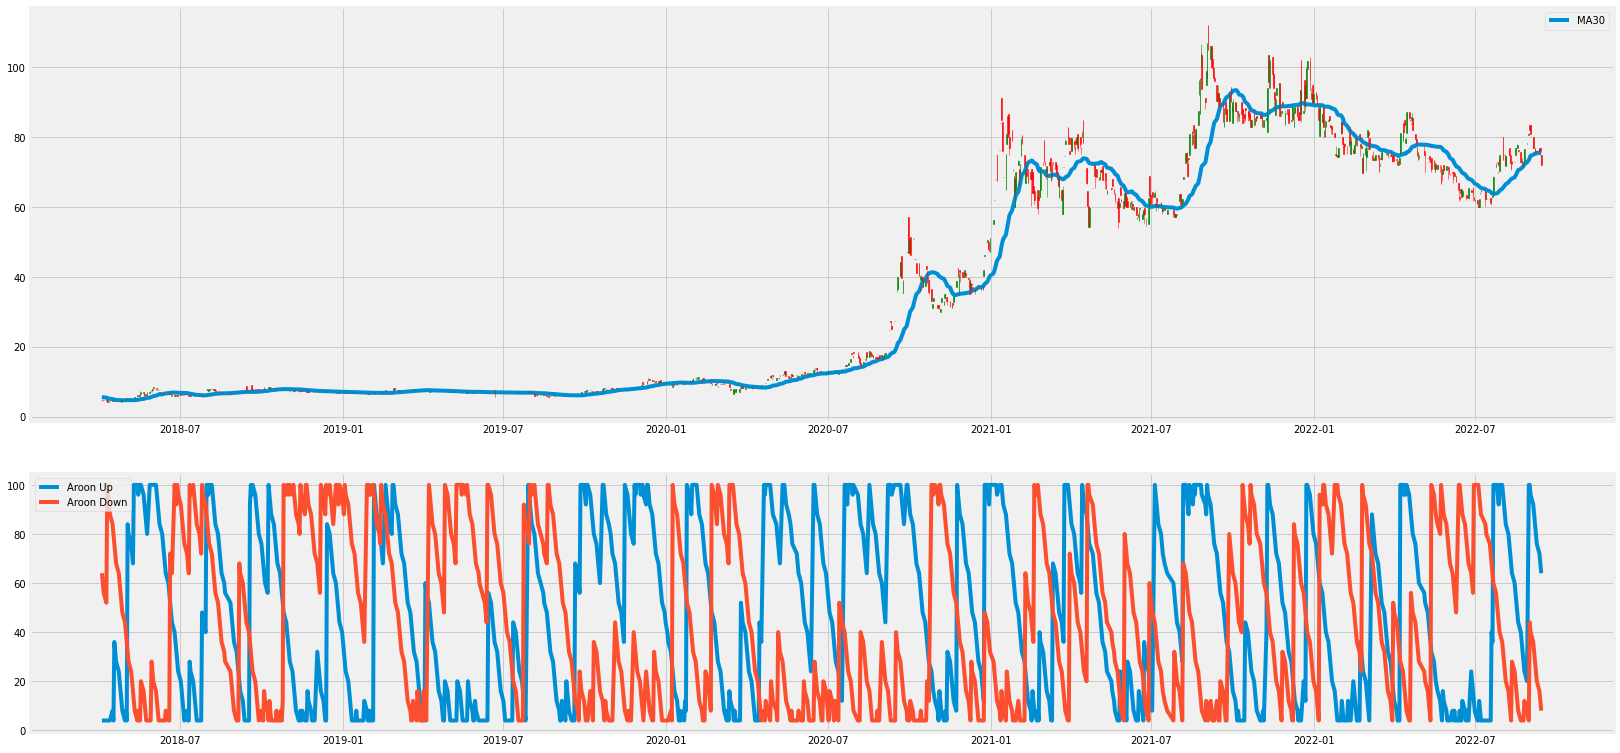

In [44]:
fig = plt.figure(figsize=(22,18))
ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
ax_aroon = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    
# Format x-axis ticks as dates
ax_candle.xaxis_date()
    
# Get nested list of date, open, high, low and close prices
ohlc = []
for date, row in data.iterrows():
    openp, highp, lowp, closep = row[:4]
    ohlc.append([date2num(date), openp, highp, lowp, closep])
 
 # Plot candlestick chart
ax_candle.plot(data.index, data["ma30"], label="MA30")
candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
ax_candle.legend()
    
# Plot Aroon
ax_aroon.plot(data.index, data["AI_U"], label="Aroon Up")
ax_aroon.plot(data.index, data["AI_D"], label="Aroon Down")
ax_aroon.legend()

In [45]:
def plot_chart(data, n):
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 16))
    ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_rsi = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    ax_candle.plot(data.index, data["ma7"], label="MA7")
    ax_candle.plot(data.index, data["ma30"], label="MA30")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    ax_candle.legend()
    
    # Plot MACD
    ax_macd.plot(data.index, data["macd"], label="macd")
    #ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    ax_macd.plot(data.index, data["signal"], label="signal")
    ax_macd.legend()
    
    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel("(%)")
    ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
    ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
    ax_rsi.plot(data.index, data["RSI"], label="rsi")
    ax_rsi.legend()
    
    plt.show()

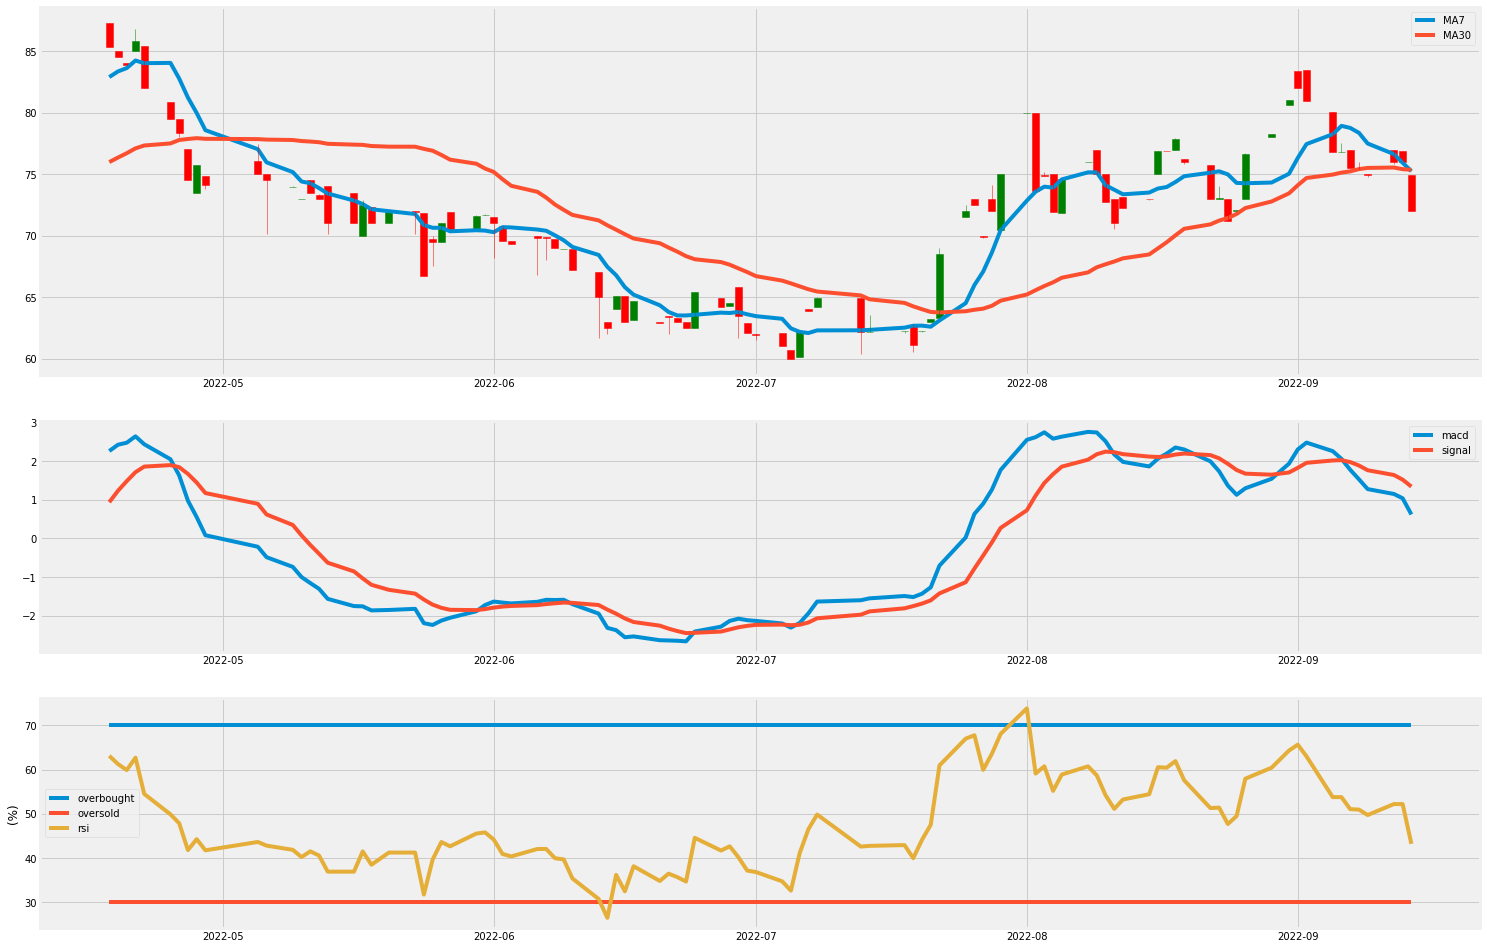

In [46]:
def Indicators_resample(df,freq):
    sample = df.copy()
    d = pd.DataFrame(index = sample.resample(freq).last().dropna().index)
    d["Open"] = sample.resample(freq).first().dropna().Open
    d["High"] = sample.resample(freq).max().dropna().High
    d["Low"] = sample.resample(freq).min().dropna().Low
    d["Close"] = sample.resample(freq).last().dropna().Close
    d["macd"] = sample.resample(freq).last().dropna().macd
    d["RSI"] = sample.resample(freq).last().dropna().RSI
    d["signal"] = sample.resample(freq).last().dropna().signal
    d["ma7"] = sample.resample(freq).last().dropna().ma7
    d["ma30"] = sample.resample(freq).last().dropna().ma30
    return d
daily = Indicators_resample(df,'1d')
plot_chart(daily, 100)

In [47]:
def RSI_backtest(df, rsi_long_start, rsi_short_start):
    sample = df.copy()
    
    # constant variables 
    entry_time = []
    exit_time = []
    trade_side = []
    rsi_value = []
    entry_price = []
    exit_price = []
    target_price = []
    stop_price = []

    # temp variables
    trade_taken = False
    target = 0
    stop = 0

    for index,datetime in enumerate(sample.index):
        # current data variables 
        current_datetime = datetime
        rsi = sample.iloc[index].loc["RSI"]
        close = sample.iloc[index].loc['Close']
        upper_band30 = sample.iloc[index].loc['upper_band30']
        lower_band30 = sample.iloc[index].loc['lower_band30']
        
        # if any trade is not taken and rsi value is between your set RSI levels, dont look for new trades 
        if (rsi > rsi_long_start) and (rsi < rsi_short_start) and (trade_taken == False):
            continue
            
        elif ((rsi >= rsi_short_start) and (trade_taken == False)):  # cheking for fresh short trade stop
            trade_taken = "short_entered"
            short_target = close*0.97
            short_stop = close*1.015
            
            entry_time.append(current_datetime)  # appending trade details
            rsi_value.append(rsi)
            trade_side.append("short")
            entry_price.append(close)
            target_price.append(short_target)
            stop_price.append(short_stop)

        elif (trade_taken == "short_entered") and (close > short_stop):    # cheking for short trade stop

            trade_taken = False
            exit_time.append(current_datetime)   # appending trade details
            exit_price.append(close)

        elif (trade_taken == "short_entered") and (close < short_target):  # cheking for short trade target 

            trade_taken = False
            exit_time.append(current_datetime)   # appending trade details
            exit_price.append(close)

        elif ((rsi < rsi_long_start) and (trade_taken == False)):     # cheking for fresh long trade 

            trade_taken = "long_entered"
            long_target = close*1.06
            long_stop = close*0.975

            entry_time.append(current_datetime)    # appending trade details
            rsi_value.append(rsi)
            trade_side.append("long")
            entry_price.append(close)
            target_price.append(long_target)
            stop_price.append(long_stop)

        elif (trade_taken == "long_entered") and (close < long_stop):   # checking for long trade stop 

            trade_taken = False
            exit_time.append(current_datetime)  
            exit_price.append(close)
        
        elif (trade_taken == "long_entered") and (close > long_target):         # checking for long trade target 

            trade_taken = False
            exit_time.append(current_datetime)  
            exit_price.append(close)

        # if last data entry and we are still holding a trade then sqaure off the trade 
        elif (index == (len(sample) - 1)) and (trade_taken != False):

            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)
        
        
    # creating a trade sheet out of all recorded trades details 
    trade_sheet = pd.DataFrame({"entry_time":entry_time,
                               "exit_time":exit_time,
                               "rsi_value":rsi_value,
                               "trade_side":trade_side,
                               "entry_price":entry_price,
                               "exit_price":exit_price,
                               "target_price":target_price,
                               "stop_price":stop_price})

    trade_sheet["pnl"] = 0   # calculating pnl from trade sheet

    con_1 = trade_sheet.trade_side == "short"
    con_2 = trade_sheet.trade_side == "long"
    trade_sheet.loc[con_1,"pnl"] = trade_sheet.loc[con_1,"entry_price"] - trade_sheet.loc[con_1,"exit_price"]
    trade_sheet.loc[con_2,"pnl"] = trade_sheet.loc[con_2,"exit_price"] - trade_sheet.loc[con_2,"entry_price"]
    return trade_sheet

In [48]:
data = df.loc['2018':].copy()
data.dropna(inplace=True)
rsi_test = RSI_backtest(data, 30, 70)

In [49]:
rsi_test.sample(5)

,entry_time,exit_time,rsi_value,trade_side,entry_price,exit_price,target_price,stop_price,pnl
10,2019-05-17,2019-06-14,28.515795,long,6.900000,6.68,7.314000,6.727500,-0.220000
37,2020-09-17,2020-09-18,85.803314,short,36.540001,40.00,35.443801,37.088101,-3.459999
8,2018-09-21,2018-09-24,72.114143,short,8.000000,7.74,7.760000,8.120000,0.260000
12,2019-09-27,2019-09-30,75.594551,short,6.900000,7.22,6.693000,7.003500,-0.320000
30,2020-07-21,2020-07-24,74.273750,short,14.860000,15.25,14.414200,15.082900,-0.390000


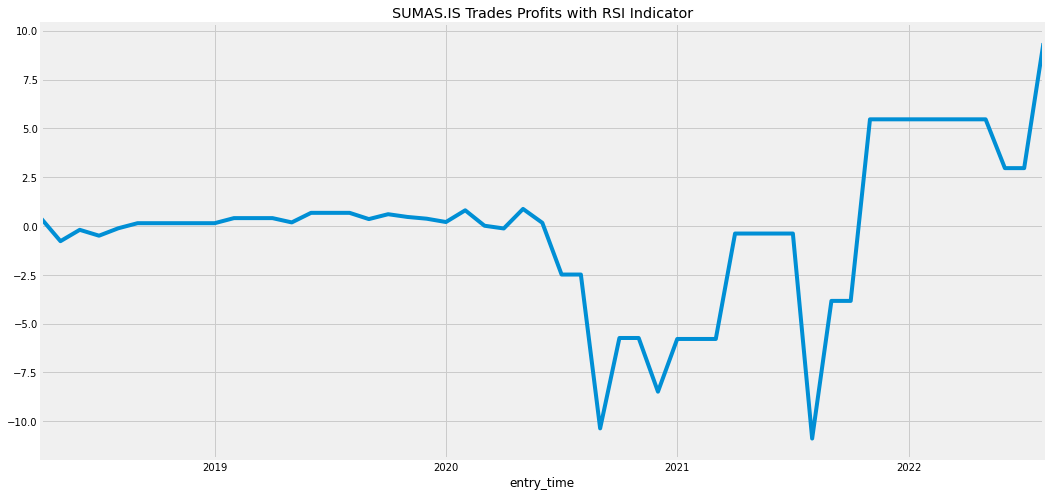

In [50]:
rsi_test.set_index("entry_time").pnl.resample("M").sum().cumsum().plot(figsize=(16,8))
plt.title("%s Trades Profits with RSI Indicator" % SYMBOL)
plt.show()

In [51]:
def MACD_backtest(df):
    
    sample = df.copy()
    
    # constant variables 
    entry_time = []
    exit_time = []

    trade_side = []
    entry_price = []
    exit_price = []

    target_price = []
    stop_price = []

    # temp variables
    trade_taken = False
    target = 0
    stop = 0
    
    # running backtest only on test data 
    for index,datetime in enumerate(sample.index):


        # current data variables 
        current_datetime = datetime
        close = sample.iloc[index].loc["Close"]
        macd = sample.iloc[index].loc["macd"]
        signal = sample.iloc[index].loc["signal"]
        ma30 = sample.iloc[index].loc['ma30']
        
        # if any trade is not taken and adf value not below a desired thresh dont look for new trades 
        #if (clo > thresh) and (trade_taken == False):
          #  continue


        # cheking for fresh short trade stop
        if ((macd < signal) and (trade_taken == False)):

            trade_taken = "short_entered"
            short_target = close*0.96
            short_stop = close*1.02

            # appending trade details
            entry_time.append(current_datetime)
            trade_side.append("short")
            entry_price.append(close)
            target_price.append(short_target)
            stop_price.append(short_stop)



        # cheking for short trade stop
        elif (trade_taken == "short_entered") and ((macd > signal) or (close < short_target)):

            trade_taken = False

            # appending trade details
            exit_time.append(current_datetime)
            exit_price.append(close)


        # cheking for short trade target 
        elif (trade_taken == "short_entered") and (close > short_stop):

            trade_taken = False

            # appending trade details
            exit_time.append(current_datetime)
            exit_price.append(close)


        # cheking for fresh long trade 
        elif ((macd >= signal) and (trade_taken == False)):

            trade_taken = "long_entered"
            long_target = close*1.04
            long_stop = close*0.98

            # appending trade details
            entry_time.append(current_datetime)
            trade_side.append("long")
            entry_price.append(close)
            target_price.append(long_target)
            stop_price.append(long_stop)


        # checking for long trade stop 
        elif (trade_taken == "long_entered") and ((macd < signal) or (close > long_target)): 

            trade_taken = False

            # appending trade details
            exit_time.append(current_datetime)
            exit_price.append(close)
            

        # checking for long trade target 
        elif (trade_taken == "long_entered") and (close < long_stop):

            trade_taken = False

            # appending trade details
            exit_time.append(current_datetime)
            exit_price.append(close)




        # if last data entry and we are still holding a trade then sqaure off the trade 
        elif (index == (len(sample) - 1)) and (trade_taken != False):

            trade_taken = False

            # appending trade details
            exit_time.append(current_datetime)
            exit_price.append(close)
            
    
    # creating a trade sheet out of all recorded trades details 
    trade_sheet = pd.DataFrame({"entry_time":entry_time,
                               "exit_time":exit_time,
                               "trade_side":trade_side,
                               "entry_price":entry_price,
                               "exit_price":exit_price,
                               "target_price":target_price,
                               "stop_price":stop_price})

    # calculating pnl from trade sheet
    trade_sheet["pnl"] = 0
    
   
    con_1 = trade_sheet.trade_side == "short"
    con_2 = trade_sheet.trade_side == "long"

    trade_sheet.loc[con_1,"pnl"] = trade_sheet.loc[con_1,"entry_price"] - trade_sheet.loc[con_1,"exit_price"]
    trade_sheet.loc[con_2,"pnl"] = trade_sheet.loc[con_2,"exit_price"] - trade_sheet.loc[con_2,"entry_price"]
    
    return trade_sheet

In [52]:
data = df.loc['2018':].copy()
data.dropna(inplace=True)
macd_test = MACD_backtest(data)

In [53]:
macd_test.sample(5)

,entry_time,exit_time,trade_side,entry_price,exit_price,target_price,stop_price,pnl
269,2022-03-01,2022-03-02,long,76.050003,82.000000,79.092003,74.529003,5.949997
103,2020-02-10,2020-02-11,long,10.000000,10.690000,10.400000,9.800000,0.690000
190,2021-02-15,2021-02-17,short,68.000000,64.000000,65.280000,69.360000,4.000000
263,2022-01-31,2022-02-01,short,84.699997,81.150002,81.311997,86.393997,3.549995
160,2020-10-16,2020-10-19,short,37.000000,39.500000,35.520000,37.740000,-2.500000


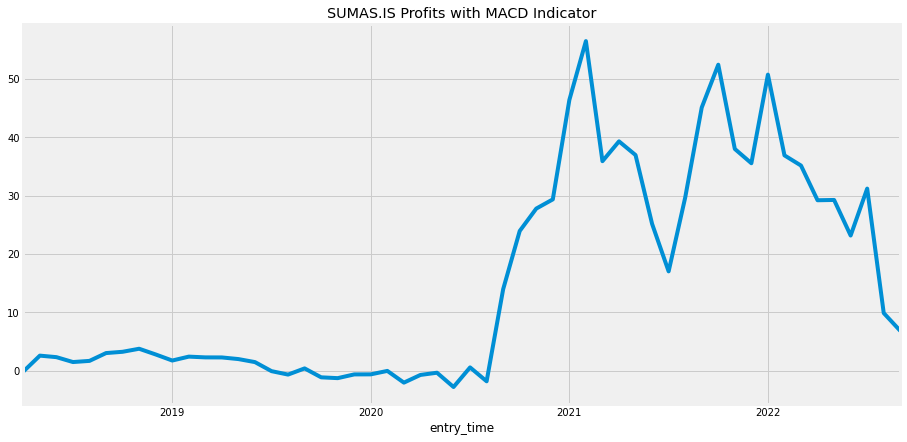

In [54]:
macd_test.set_index("entry_time").pnl.resample("M").sum().cumsum().plot(figsize=(14,7))
plt.title("%s Profits with MACD Indicator" % SYMBOL)
plt.show()

In [55]:
def AOI_backtest(df,upper_thresh,lower_thresh):
    sample = df.copy()
    entry_time = []
    exit_time = []

    trade_side = []
    entry_price = []
    exit_price = []
    target_price = []
    stop_price = []

    trade_taken = False
    target = 0
    stop = 0
    
    for index,datetime in enumerate(sample.index):
        current_datetime = datetime
        close = sample.iloc[index].loc["Close"]
        AOI = sample.iloc[index].loc["AOI"]
        
        if (AOI > lower_thresh) and (AOI < upper_thresh) and (trade_taken == False):
            continue
            
        if ((upper_thresh < AOI) and (trade_taken == False)):
            trade_taken = "short_entered"
            short_target = close*0.97
            short_stop = close*1.015

            entry_time.append(current_datetime)
            trade_side.append("short")
            entry_price.append(close)
            target_price.append(short_target)
            stop_price.append(short_stop)

        elif (trade_taken == "short_entered") and (close > short_stop):
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)
            
        elif (trade_taken == "short_entered") and (close < short_target):
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)

        elif ((lower_thresh >= AOI) and (trade_taken == False)):
            trade_taken = "long_entered"
            long_target = close*1.05
            long_stop = close*0.975

            entry_time.append(current_datetime)
            trade_side.append("long")
            entry_price.append(close)
            target_price.append(long_target)
            stop_price.append(long_stop)

        elif (trade_taken == "long_entered") and (close > long_target): 
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)
            
        elif (trade_taken == "long_entered") and (close < long_stop):
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)

        elif (index == (len(sample) - 1)) and (trade_taken != False):
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)
    
    trade_sheet = pd.DataFrame({"entry_time":entry_time,
                               "exit_time":exit_time,
                               "trade_side":trade_side,
                               "entry_price":entry_price,
                               "exit_price":exit_price,
                               "target_price":target_price,
                               "stop_price":stop_price})

    # calculating pnl from trade sheet
    trade_sheet["pnl"] = 0
    con_1 = trade_sheet.trade_side == "short"
    con_2 = trade_sheet.trade_side == "long"
    trade_sheet.loc[con_1,"pnl"] = trade_sheet.loc[con_1,"entry_price"] - trade_sheet.loc[con_1,"exit_price"]
    trade_sheet.loc[con_2,"pnl"] = trade_sheet.loc[con_2,"exit_price"] - trade_sheet.loc[con_2,"entry_price"]    
    return trade_sheet

In [56]:
data = df.loc['2018':].copy()
data.dropna(inplace=True)
AOI_test = AOI_backtest(data,10,-10)

In [57]:
AOI_test.sample(5)

,entry_time,exit_time,trade_side,entry_price,exit_price,target_price,stop_price,pnl
19,2021-08-16,2021-08-17,short,77.800003,80.599998,75.466003,78.967003,-2.799995
18,2021-08-12,2021-08-13,short,73.650002,81.000000,71.440501,74.754752,-7.349998
26,2021-09-08,2021-09-10,short,99.900002,96.000000,96.903001,101.398502,3.900002
20,2021-08-18,2021-08-19,short,81.199997,77.000000,78.763997,82.417997,4.199997
7,2020-10-08,2020-10-09,short,45.139999,41.119999,43.785799,45.817099,4.020000


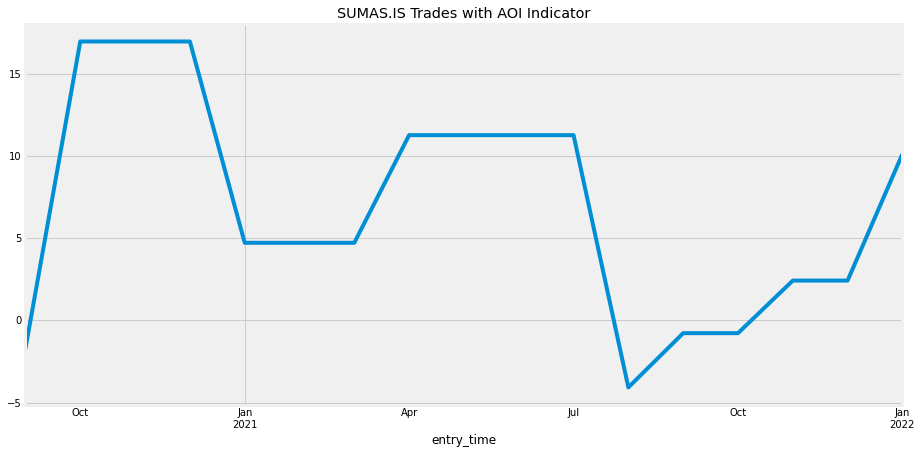

In [58]:
AOI_test.set_index("entry_time").pnl.resample("M").sum().cumsum().plot(figsize=(14,7))
plt.title("%s Trades with AOI Indicator" % SYMBOL)
plt.show()

In [59]:
def KAMA_backtest(df):
    sample = df.copy()
    entry_time = []
    exit_time = []

    trade_side = []
    entry_price = []
    exit_price = []
    target_price = []
    stop_price = []

    trade_taken = False
    target = 0
    stop = 0
    
    for index,datetime in enumerate(sample.index):
        current_datetime = datetime
        close = sample.iloc[index].loc["Close"]
        KAMA_FAST = sample.iloc[index].loc["KAMA_FAST"]
        KAMA_SLOW = sample.iloc[index].loc['KAMA_SLOW']
        
       # if (AOI > lower_thresh) and (AOI < upper_thresh) and (trade_taken == False):
       #     continue
            
        if ((KAMA_FAST < KAMA_SLOW) and (trade_taken == False)):
            trade_taken = "short_entered"
            short_target = close*0.97
            short_stop = close*1.015

            entry_time.append(current_datetime)
            trade_side.append("short")
            entry_price.append(close)
            target_price.append(short_target)
            stop_price.append(short_stop)

        elif (trade_taken == "short_entered") and (close > short_stop):
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)
            
        elif (trade_taken == "short_entered") and (close < short_target):
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)

        elif ((KAMA_FAST >= KAMA_SLOW) and (trade_taken == False)):
            trade_taken = "long_entered"
            long_target = close*1.05
            long_stop = close*0.98

            entry_time.append(current_datetime)
            trade_side.append("long")
            entry_price.append(close)
            target_price.append(long_target)
            stop_price.append(long_stop)

        elif (trade_taken == "long_entered") and (close > long_target): 
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)
            
        elif (trade_taken == "long_entered") and (close < long_stop):
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)

        elif (index == (len(sample) - 1)) and (trade_taken != False):
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)
    
    trade_sheet = pd.DataFrame({"entry_time":entry_time,
                               "exit_time":exit_time,
                               "trade_side":trade_side,
                               "entry_price":entry_price,
                               "exit_price":exit_price,
                               "target_price":target_price,
                               "stop_price":stop_price})

    # calculating pnl from trade sheet
    trade_sheet["pnl"] = 0
    con_1 = trade_sheet.trade_side == "short"
    con_2 = trade_sheet.trade_side == "long"
    trade_sheet.loc[con_1,"pnl"] = trade_sheet.loc[con_1,"entry_price"] - trade_sheet.loc[con_1,"exit_price"]
    trade_sheet.loc[con_2,"pnl"] = trade_sheet.loc[con_2,"exit_price"] - trade_sheet.loc[con_2,"entry_price"]    
    return trade_sheet

In [60]:
data = df.copy()
data.dropna(inplace=True)
KAMA_test = KAMA_backtest(data)

In [61]:
KAMA_test.sample(5)

,entry_time,exit_time,trade_side,entry_price,exit_price,target_price,stop_price,pnl
53,2019-02-14,2019-02-18,long,6.750000,7.120000,7.087500,6.615000,0.370000
246,2022-03-03,2022-03-04,long,80.550003,76.550003,84.577503,78.939003,-4.000000
137,2020-09-30,2020-10-01,long,46.720001,50.849998,49.056001,45.785601,4.129997
66,2019-08-27,2019-08-29,short,6.100000,5.900000,5.917000,6.191500,0.200000
15,2018-06-08,2018-06-11,short,6.440000,6.100000,6.246800,6.536600,0.340000


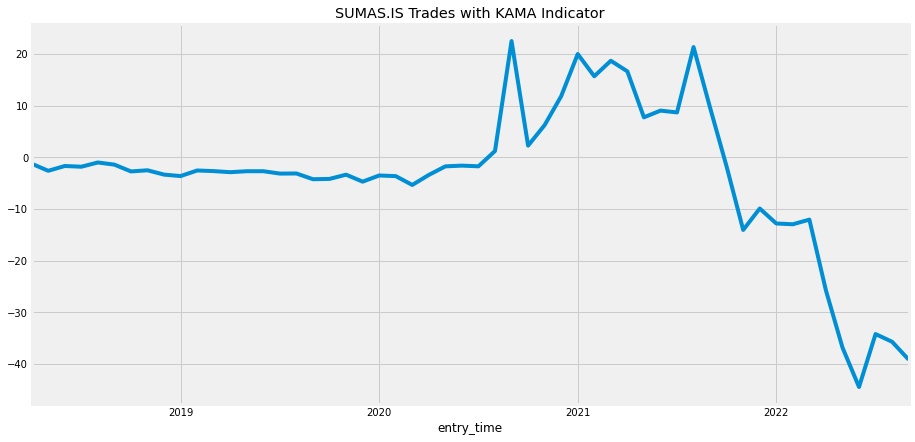

In [62]:
KAMA_test.set_index("entry_time").pnl.resample("M").sum().cumsum().plot(figsize=(14,7))
plt.title("%s Trades with KAMA Indicator" % SYMBOL)
plt.show()

In [63]:
def ROC_backtest(df,upper_thresh,lower_thresh):
    sample = df.copy()
    entry_time = []
    exit_time = []

    trade_side = []
    entry_price = []
    exit_price = []
    target_price = []
    stop_price = []

    trade_taken = False
    target = 0
    stop = 0
    
    for index,datetime in enumerate(sample.index):
        current_datetime = datetime
        close = sample.iloc[index].loc["Close"]
        ROC = sample.iloc[index].loc["ROC"]
        
        if (ROC > lower_thresh) and (ROC < upper_thresh) and (trade_taken == False):
            continue
            
        if ((upper_thresh < ROC) and (trade_taken == False)):
            trade_taken = "short_entered"
            short_target = close*0.97
            short_stop = close*1.015

            entry_time.append(current_datetime)
            trade_side.append("short")
            entry_price.append(close)
            target_price.append(short_target)
            stop_price.append(short_stop)

        elif (trade_taken == "short_entered") and (close > short_stop):
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)
            
        elif (trade_taken == "short_entered") and (close < short_target):
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)

        elif ((lower_thresh >= ROC) and (trade_taken == False)):
            trade_taken = "long_entered"
            long_target = close*1.05
            long_stop = close*0.975

            entry_time.append(current_datetime)
            trade_side.append("long")
            entry_price.append(close)
            target_price.append(long_target)
            stop_price.append(long_stop)

        elif (trade_taken == "long_entered") and (close > long_target): 
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)
            
        elif (trade_taken == "long_entered") and (close < long_stop):
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)

        elif (index == (len(sample) - 1)) and (trade_taken != False):
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)
    
    trade_sheet = pd.DataFrame({"entry_time":entry_time,
                               "exit_time":exit_time,
                               "trade_side":trade_side,
                               "entry_price":entry_price,
                               "exit_price":exit_price,
                               "target_price":target_price,
                               "stop_price":stop_price})

    # calculating pnl from trade sheet
    trade_sheet["pnl"] = 0
    con_1 = trade_sheet.trade_side == "short"
    con_2 = trade_sheet.trade_side == "long"
    trade_sheet.loc[con_1,"pnl"] = trade_sheet.loc[con_1,"entry_price"] - trade_sheet.loc[con_1,"exit_price"]
    trade_sheet.loc[con_2,"pnl"] = trade_sheet.loc[con_2,"exit_price"] - trade_sheet.loc[con_2,"entry_price"]    
    return trade_sheet

In [64]:
data = df.loc['2018':].copy()
data.dropna(inplace=True)
ROC_test = ROC_backtest(data,20,-20)

In [65]:
ROC_test.sample(5)

,entry_time,exit_time,trade_side,entry_price,exit_price,target_price,stop_price,pnl
33,2020-09-14,2020-09-15,short,27.459999,30.200001,26.636199,27.871899,-2.740002
10,2018-06-25,2018-07-12,long,6.000000,5.850000,6.300000,5.850000,-0.150000
18,2019-12-10,2019-12-11,short,10.100000,10.860000,9.797000,10.251500,-0.759999
4,2018-05-22,2018-05-24,short,6.220000,6.480000,6.033400,6.313300,-0.260000
48,2020-11-25,2020-11-26,short,40.000000,41.000000,38.800000,40.600000,-1.000000


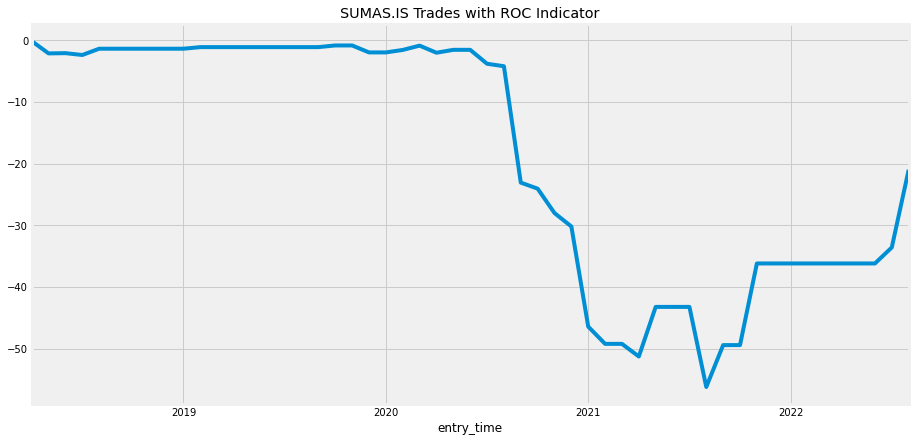

In [66]:
ROC_test.set_index("entry_time").pnl.resample("M").sum().cumsum().plot(figsize=(14,7))
plt.title("%s Trades with ROC Indicator" % SYMBOL)
plt.show()

In [67]:
def Stoch_backtest(df,upper_thresh,lower_thresh,stoch):
    sample = df.copy()
    entry_time = []
    exit_time = []

    trade_side = []
    entry_price = []
    exit_price = []
    target_price = []
    stop_price = []

    trade_taken = False
    target = 0
    stop = 0
    
    for index,datetime in enumerate(sample.index):
        current_datetime = datetime
        close = sample.iloc[index].loc["Close"]
        SRSI = sample.iloc[index].loc[stoch]
        
        if (SRSI > lower_thresh) and (SRSI < upper_thresh) and (trade_taken == False):
            continue
            
        if ((upper_thresh < SRSI) and (trade_taken == False)):
            trade_taken = "short_entered"
            short_target = close*0.97
            short_stop = close*1.015

            entry_time.append(current_datetime)
            trade_side.append("short")
            entry_price.append(close)
            target_price.append(short_target)
            stop_price.append(short_stop)

        elif (trade_taken == "short_entered") and (close > short_stop):
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)
            
        elif (trade_taken == "short_entered") and (close < short_target):
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)

        elif ((lower_thresh >= SRSI) and (trade_taken == False)):
            trade_taken = "long_entered"
            long_target = close*1.05
            long_stop = close*0.975

            entry_time.append(current_datetime)
            trade_side.append("long")
            entry_price.append(close)
            target_price.append(long_target)
            stop_price.append(long_stop)

        elif (trade_taken == "long_entered") and (close > long_target): 
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)
            
        elif (trade_taken == "long_entered") and (close < long_stop):
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)

        elif (index == (len(sample) - 1)) and (trade_taken != False):
            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)
    
    trade_sheet = pd.DataFrame({"entry_time":entry_time,
                               "exit_time":exit_time,
                               "trade_side":trade_side,
                               "entry_price":entry_price,
                               "exit_price":exit_price,
                               "target_price":target_price,
                               "stop_price":stop_price})

    # calculating pnl from trade sheet
    trade_sheet["pnl"] = 0
    con_1 = trade_sheet.trade_side == "short"
    con_2 = trade_sheet.trade_side == "long"
    trade_sheet.loc[con_1,"pnl"] = trade_sheet.loc[con_1,"entry_price"] - trade_sheet.loc[con_1,"exit_price"]
    trade_sheet.loc[con_2,"pnl"] = trade_sheet.loc[con_2,"exit_price"] - trade_sheet.loc[con_2,"entry_price"]    
    return trade_sheet

In [68]:
data = df.loc['2018':].copy()
data.dropna(inplace=True)
Stoch3_test = Stoch_backtest(data,0.8,0.2,'STOCH_RSI3')

In [69]:
Stoch3_test.sample(5)

,entry_time,exit_time,trade_side,entry_price,exit_price,target_price,stop_price,pnl
50,2020-01-27,2020-01-30,short,9.900000,10.48,9.603000,10.048500,-0.580000
106,2021-02-15,2021-02-17,long,68.000000,64.00,71.400000,66.300000,-4.000000
47,2019-12-24,2020-01-03,long,9.990000,9.00,10.489500,9.740250,-0.990000
92,2020-11-24,2020-11-25,short,42.580002,40.00,41.302602,43.218702,2.580002
91,2020-11-12,2020-11-16,short,33.000000,31.52,32.010000,33.495000,1.480000


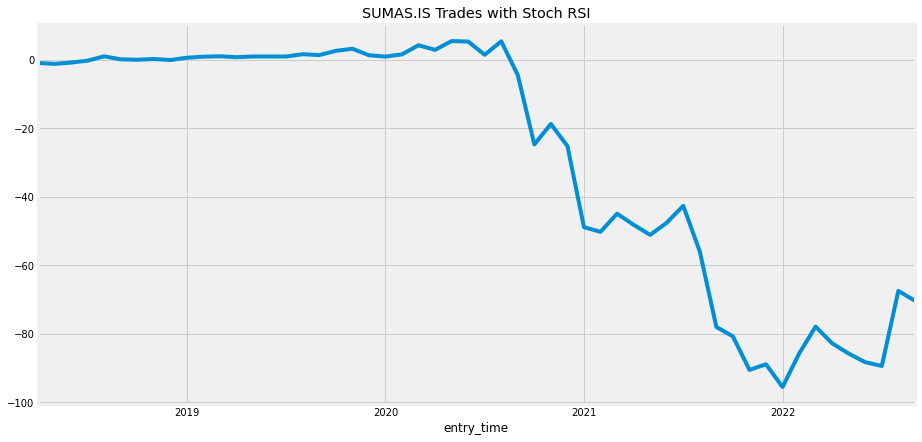

In [70]:
Stoch3_test.set_index("entry_time").pnl.resample("M").sum().cumsum().plot(figsize=(14,7))
plt.title("%s Trades with Stoch RSI" % SYMBOL)
plt.show()

In [71]:
data = df.loc['2018':].copy()
data.dropna(inplace=True)
Stoch10_test = Stoch_backtest(data,0.8,0.2,'STOCH_RSI10')
Stoch10_test.sample(5)

,entry_time,exit_time,trade_side,entry_price,exit_price,target_price,stop_price,pnl
82,2021-11-29,2021-12-03,long,86.949997,84.150002,91.297497,84.776247,-2.799995
30,2019-10-09,2019-10-18,short,7.100000,7.210000,6.887000,7.206500,-0.110000
43,2020-05-29,2020-06-05,long,11.620000,12.400000,12.201000,11.329500,0.780000
37,2020-02-03,2020-02-07,short,11.150000,10.700000,10.815500,11.317250,0.450000
75,2021-04-22,2021-04-26,long,59.599998,65.550003,62.579998,58.109999,5.950005


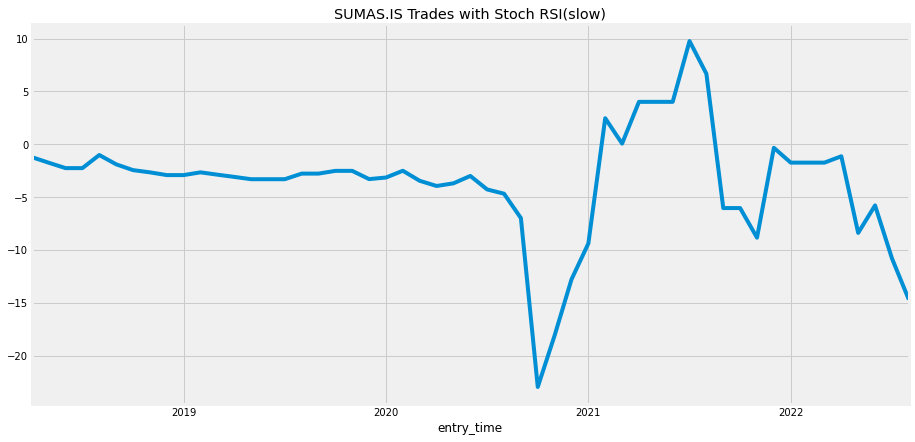

In [72]:
Stoch10_test.set_index("entry_time").pnl.resample("M").sum().cumsum().plot(figsize=(14,7))
plt.title("%s Trades with Stoch RSI(slow)" % SYMBOL)
plt.show()

In [73]:
df = df.dropna()
X = df.drop(columns=['Close', 'Vol_change'],axis=1)
y = df.Close
X.head(3)
X.describe()

,Open,High,Low,ma7,ma30,upper_band7,lower_band7,upper_band30,lower_band30,ema_fast,ema_slow,macd,signal,AOI,KAMA_FAST,KAMA_SLOW,ROC,RSI,STOCH_RSI,STOCH_RSI3,STOCH_RSI10,TSI_FAST,TSI_SLOW,WRI_FAST,ATR2,ATR,DC_HB,DC_LB,DC_MB,AI_D,AI_I,AI_U
count,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1.123000e+03,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000
mean,36.012634,36.502899,35.240803,35.645878,34.919422,38.598099,32.693645,40.641991,29.196854,35.486137,35.056515,0.429623,0.423338,0.915987,30.568945,21.134739,4.261000,52.037804,0.481611,4.823572e-01,0.484660,-3.940307,3.691063,-51.215904,1.660588,1.639729,40.557339,30.945705,35.751522,45.196793,3.077471,48.274265
std,32.751488,33.238594,31.975325,32.455009,32.105469,35.181858,29.947615,37.055660,27.989832,32.322037,32.073490,2.048550,1.898325,5.476801,28.726082,19.246075,18.021997,11.633014,0.346511,3.079387e-01,0.239040,72.271484,20.668957,30.379183,2.249371,1.691721,37.035290,28.762487,32.706177,33.336926,58.587688,34.594822
min,4.170000,4.330000,4.050000,4.432857,4.657333,4.674719,3.936998,5.116296,3.457274,4.532341,4.748921,-3.448717,-2.630169,-10.464706,6.067810,6.650628,-30.512819,24.199787,0.000000,3.700744e-17,0.026886,-99.999756,-68.750229,-100.000000,0.000000,0.072654,4.990000,3.760000,4.380000,4.000000,-96.000000,4.000000
25%,7.235000,7.285000,7.120000,7.204286,7.093167,7.556895,6.882703,7.979537,6.650882,7.204225,7.145034,-0.224415,-0.196390,-0.668441,7.022666,6.871459,-4.750470,43.606472,0.151797,2.000556e-01,0.285211,-77.809872,-11.022224,-75.641006,0.150000,0.222968,7.900000,6.700000,7.255000,12.000000,-52.000000,12.000000
50%,12.490000,12.750000,12.250000,12.515715,11.988334,13.199791,11.827895,13.475519,8.831740,12.591529,12.061364,0.013677,0.058131,-0.000971,9.849917,8.025565,0.000000,49.611496,0.481145,4.933723e-01,0.492421,-8.084447,0.546116,-54.385963,0.540000,0.509102,13.900000,11.090000,12.500000,40.000000,16.000000,44.000000
75%,71.500000,71.950001,69.849998,70.442856,69.286667,76.059181,64.178604,81.063362,58.504400,70.201180,69.014744,0.572076,0.569203,1.201485,56.884171,34.833523,8.748164,59.575901,0.784779,7.509666e-01,0.678797,67.767735,18.278988,-26.712856,2.500000,2.940610,80.000000,58.750000,69.550003,76.000000,56.000000,80.000000
max,112.000000,112.000000,105.000000,101.978569,93.466667,113.980110,94.121124,115.032074,82.557190,97.054611,90.850922,11.010528,9.422913,31.123676,78.819603,61.004673,149.604507,89.871902,1.000000,1.000000e+00,0.961736,99.972321,64.857895,-0.000000,17.750000,5.962150,112.000000,84.449997,97.750000,100.000000,96.000000,100.000000


In [74]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state = 0)

In [75]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=4)
model = model.fit(X_train, y_train)
pred = model.predict(X_test)

In [76]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print(r2_score(y_test, pred))
print(mean_absolute_error(y_test,pred))

0.9962226570389661
1.373762258136169


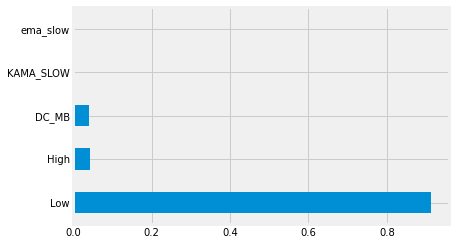

In [77]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')

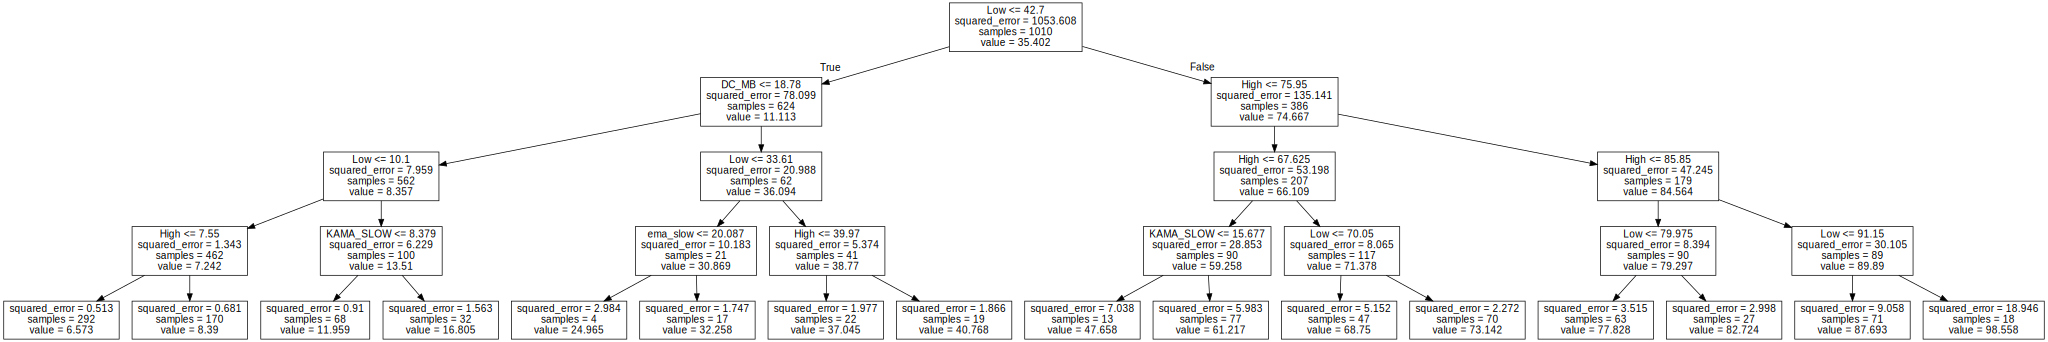

In [78]:
from graphviz import Source
from sklearn import tree
Source( tree.export_graphviz(model, out_file=None, feature_names=X.columns))

In [79]:
### Without Open, High, Close, Low
X_train = X_train.drop(['Open','High','Low'],axis=1)
X_test = X_test.drop(['Open','High','Low'],axis=1)
model2 = DecisionTreeRegressor(max_depth=8)
model2 = model2.fit(X_train,y_train)
pred2 = model2.predict(X_test)
print(r2_score(y_test,pred2))

0.9971398731079588


In [80]:
print(mean_absolute_error(y_test,pred2))

0.9959597847076652


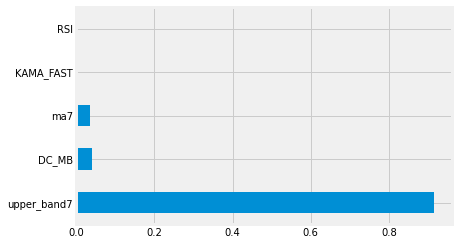

In [81]:
feat_importances = pd.Series(model2.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')

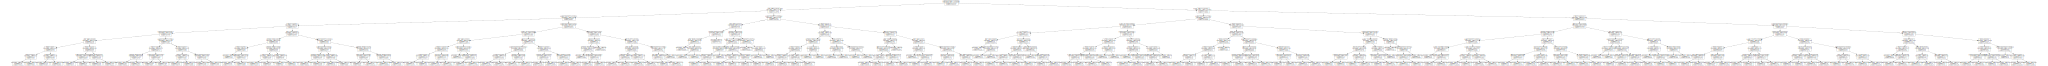

In [82]:
Source( tree.export_graphviz(model2, out_file=None, feature_names=X_train.columns))

In [83]:
from sklearn.linear_model import Lasso
model3 = Lasso(alpha=0.1)
model3 = model3.fit(X_train,y_train)
pred3 = model3.predict(X_test)
print(r2_score(y_test,pred3))

0.996856339655214


In [84]:
print(mean_absolute_error(y_test,pred3))

1.1589718


ma7 Score: 0.57413
ma30 Score: 0.14736
upper_band7 Score: 0.01928
lower_band7 Score: -0.16346
upper_band30 Score: 0.07204
lower_band30 Score: 0.12681
ema_fast Score: 0.11538
ema_slow Score: -0.00000
macd Score: 2.42870
signal Score: -1.50762
AOI Score: 0.00000
KAMA_FAST Score: 0.02616
KAMA_SLOW Score: -0.00703
ROC Score: 0.02554
RSI Score: 0.05076
STOCH_RSI Score: -0.00000
STOCH_RSI3 Score: -0.00000
STOCH_RSI10 Score: -0.00000
TSI_FAST Score: 0.00896
TSI_SLOW Score: -0.02794
WRI_FAST Score: 0.00412
ATR2 Score: 0.03531
ATR Score: -0.00000
DC_HB Score: 0.04258
DC_LB Score: 0.03546
DC_MB Score: 0.00283
AI_D Score: 0.00000
AI_I Score: -0.00050
AI_U Score: -0.00382


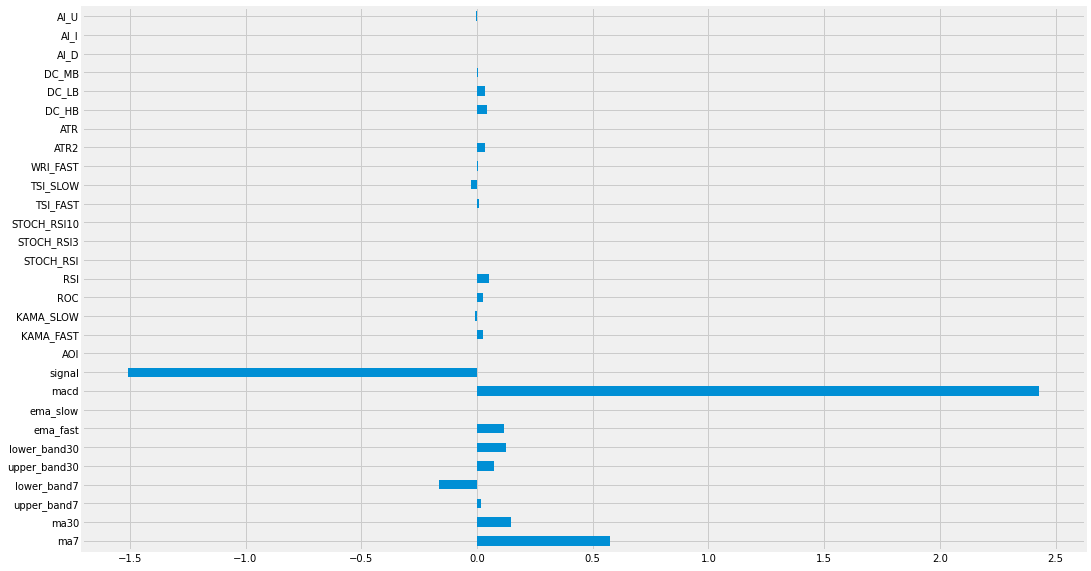

In [85]:
importance = model3.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print(X_train.columns[i] + ' Score: %.5f' % v)
# plot feature importance
feat_importances = pd.Series(importance, index=X_train.columns)
feat_importances.plot(kind='barh',figsize=(16,10))

bir usttekinde KAMA_FAST cok iyiydi, digerinde ise MACD biz ikisini alabiliriz

In [86]:
def RSI_KAMA_backtest(df,rsi_upper, rsi_lower):
    sample = df.copy()
    
    # constant variables 
    entry_time = []
    exit_time = []
    trade_side = []
    rsi_value = []
    entry_price = []
    exit_price = []
    target_price = []
    stop_price = []

    # temp variables
    trade_taken = False
    target = 0
    stop = 0

    for index,datetime in enumerate(sample.index):
        current_datetime = datetime
        rsi = sample.iloc[index].loc["RSI"]
        close = sample.iloc[index].loc['Close']
        kama_fast = sample.iloc[index].loc['KAMA_FAST']
        kama_slow = sample.iloc[index].loc['KAMA_SLOW']
        
        # if any trade is not taken and rsi value is between your set RSI levels, dont look for new trades 
        if (rsi > rsi_lower) and (rsi < rsi_upper) and (trade_taken == False):
            continue
            
        elif (((kama_slow >= kama_fast) and (rsi > rsi_upper)) and (trade_taken == False)):
            trade_taken = "short_entered"
            short_target = close*0.97
            short_stop = close*1.015
            
            entry_time.append(current_datetime) 
            rsi_value.append(rsi)
            trade_side.append("short")
            entry_price.append(close)
            target_price.append(short_target)
            stop_price.append(short_stop)

        elif (trade_taken == "short_entered") and (close > short_stop):  
            trade_taken = False
            exit_time.append(current_datetime)  
            exit_price.append(close)

        elif (trade_taken == "short_entered") and (close < short_target): 

            trade_taken = False
            exit_time.append(current_datetime) 
            exit_price.append(close)

        elif (((rsi < rsi_lower) and (kama_fast > kama_slow)) and (trade_taken == False)):    

            trade_taken = "long_entered"
            long_target = close*1.05
            long_stop = close*0.975

            entry_time.append(current_datetime)  
            rsi_value.append(rsi)
            trade_side.append("long")
            entry_price.append(close)
            target_price.append(long_target)
            stop_price.append(long_stop)

        elif (trade_taken == "long_entered") and (close < long_stop): 

            trade_taken = False
            exit_time.append(current_datetime)  
            exit_price.append(close)
        
        elif (trade_taken == "long_entered") and (close > long_target):    

            trade_taken = False
            exit_time.append(current_datetime)  
            exit_price.append(close)

        # if last data entry and we are still holding a trade then sqaure off the trade 
        elif (index == (len(sample) - 1)) and (trade_taken != False):

            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)
        
        
    # creating a trade sheet out of all recorded trades details 
    trade_sheet = pd.DataFrame({"entry_time":entry_time,
                               "exit_time":exit_time,
                               "rsi_value":rsi_value,
                               "trade_side":trade_side,
                               "entry_price":entry_price,
                               "exit_price":exit_price,
                               "target_price":target_price,
                               "stop_price":stop_price})

    trade_sheet["pnl"] = 0  

    con_1 = trade_sheet.trade_side == "short"
    con_2 = trade_sheet.trade_side == "long"
    trade_sheet.loc[con_1,"pnl"] = trade_sheet.loc[con_1,"entry_price"] - trade_sheet.loc[con_1,"exit_price"]
    trade_sheet.loc[con_2,"pnl"] = trade_sheet.loc[con_2,"exit_price"] - trade_sheet.loc[con_2,"entry_price"]
    return trade_sheet

In [87]:
rsi_kama_test = RSI_KAMA_backtest(df,70,30)
rsi_kama_test.sample(5)

,entry_time,exit_time,rsi_value,trade_side,entry_price,exit_price,target_price,stop_price,pnl
8,2019-06-17,2019-07-29,28.675550,long,6.690000,7.180000,7.024500,6.522750,0.490000
13,2021-04-21,2021-04-22,29.864750,long,54.200001,59.599998,56.910001,52.845001,5.399998
10,2019-10-01,2019-10-02,73.680107,short,7.080000,7.200000,6.867600,7.186200,-0.120000
12,2020-03-13,2020-03-16,29.390762,long,7.950000,7.160000,8.347500,7.751250,-0.790000
3,2018-05-31,2018-06-01,75.610748,short,7.800000,8.080000,7.566000,7.917000,-0.280000


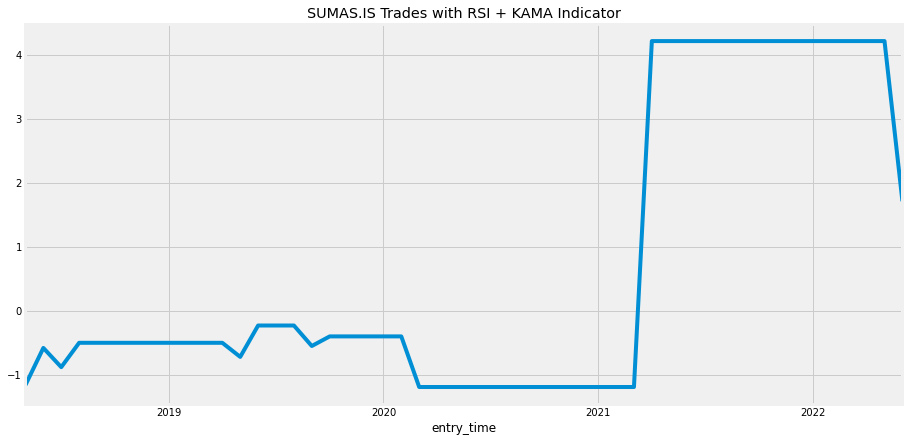

In [88]:
rsi_kama_test.set_index('entry_time').pnl.resample('M').sum().cumsum().plot(figsize=(14,7))
plt.title("%s Trades with RSI + KAMA Indicator" % SYMBOL)
plt.show()

In [89]:
def MACD_KAMA_backtest(df):
    sample = df.copy()
    
    # constant variables 
    entry_time = []
    exit_time = []
    trade_side = []
    rsi_value = []
    entry_price = []
    exit_price = []
    target_price = []
    stop_price = []

    # temp variables
    trade_taken = False
    target = 0
    stop = 0

    for index,datetime in enumerate(sample.index):
        current_datetime = datetime
        macd = sample.iloc[index].loc["macd"]
        signal = sample.iloc[index].loc["signal"]
        close = sample.iloc[index].loc['Close']
        kama_fast = sample.iloc[index].loc['KAMA_FAST']
        kama_slow = sample.iloc[index].loc['KAMA_SLOW']
        
       # if (rsi > rsi_lower) and (rsi < rsi_upper) and (trade_taken == False):
        #    continue
            
        if (((kama_slow >= kama_fast) and (signal > macd)) and (trade_taken == False)):
            trade_taken = "short_entered"
            short_target = close*0.97
            short_stop = close*1.015
            
            entry_time.append(current_datetime) 
            trade_side.append("short")
            entry_price.append(close)
            target_price.append(short_target)
            stop_price.append(short_stop)

        elif (trade_taken == "short_entered") and (close > short_stop):  
            trade_taken = False
            exit_time.append(current_datetime)  
            exit_price.append(close)

        elif (trade_taken == "short_entered") and (close < short_target): 

            trade_taken = False
            exit_time.append(current_datetime) 
            exit_price.append(close)
            
        elif (trade_taken == "short_entered") and ((kama_slow < kama_fast) and (signal < macd)): 

            trade_taken = False
            exit_time.append(current_datetime) 
            exit_price.append(close)

        elif (((signal < macd) and (kama_slow < kama_fast)) and (trade_taken == False)):    

            trade_taken = "long_entered"
            long_target = close*1.05
            long_stop = close*0.975

            entry_time.append(current_datetime)  
            trade_side.append("long")
            entry_price.append(close)
            target_price.append(long_target)
            stop_price.append(long_stop)

        elif (trade_taken == "long_entered") and (close < long_stop): 

            trade_taken = False
            exit_time.append(current_datetime)  
            exit_price.append(close)
        
        elif (trade_taken == "long_entered") and (close > long_target):    

            trade_taken = False
            exit_time.append(current_datetime)  
            exit_price.append(close)
            
        elif (trade_taken == "long_entered") and ((signal > macd) and (kama_slow > kama_fast)):    

            trade_taken = False
            exit_time.append(current_datetime)  
            exit_price.append(close)

        # if last data entry and we are still holding a trade then sqaure off the trade 
        elif (index == (len(sample) - 1)) and (trade_taken != False):

            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)
        
        
    # creating a trade sheet out of all recorded trades details 
    trade_sheet = pd.DataFrame({"entry_time":entry_time,
                               "exit_time":exit_time,
                               "trade_side":trade_side,
                               "entry_price":entry_price,
                               "exit_price":exit_price,
                               "target_price":target_price,
                               "stop_price":stop_price})

    trade_sheet["pnl"] = 0  

    con_1 = trade_sheet.trade_side == "short"
    con_2 = trade_sheet.trade_side == "long"
    trade_sheet.loc[con_1,"pnl"] = trade_sheet.loc[con_1,"entry_price"] - trade_sheet.loc[con_1,"exit_price"]
    trade_sheet.loc[con_2,"pnl"] = trade_sheet.loc[con_2,"exit_price"] - trade_sheet.loc[con_2,"entry_price"]
    return trade_sheet

In [90]:
macd_kama_test = MACD_KAMA_backtest(df)
macd_kama_test.sample(5)

,entry_time,exit_time,trade_side,entry_price,exit_price,target_price,stop_price,pnl
141,2022-04-20,2022-04-25,long,83.900002,79.5,88.095002,81.802501,-4.400002
41,2019-10-22,2019-11-01,long,8.150000,7.8,8.557500,7.946250,-0.349999
95,2021-03-01,2021-03-04,long,72.000000,69.0,75.600000,70.200000,-3.000000
10,2018-07-26,2018-07-27,short,5.700000,5.8,5.529000,5.785500,-0.100000
43,2019-12-06,2019-12-10,long,9.370000,10.1,9.838500,9.135750,0.730000


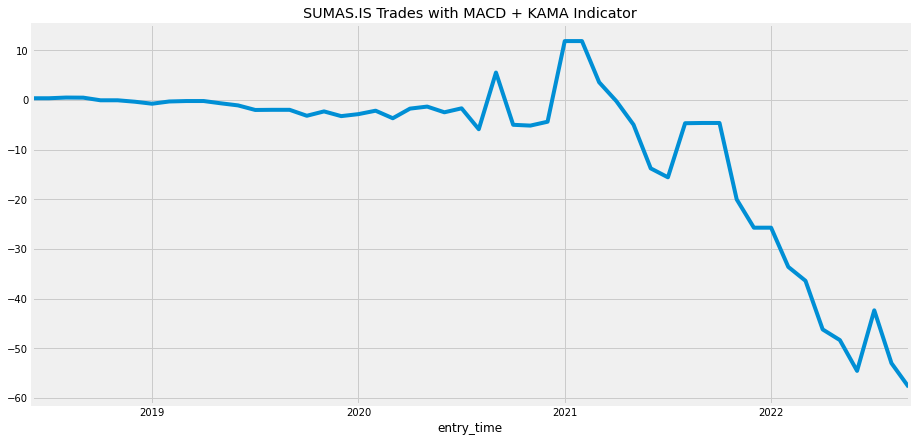

In [91]:
macd_kama_test.set_index('entry_time').pnl.resample('M').sum().cumsum().plot(figsize=(14,7))
plt.title("%s Trades with MACD + KAMA Indicator" % SYMBOL)
plt.show()

In [92]:
def ATR_MACD_KAMA_backtest(df):
    sample = df.copy()
    
    # constant variables 
    entry_time = []
    exit_time = []
    trade_side = []
    rsi_value = []
    entry_price = []
    exit_price = []
    target_price = []
    stop_price = []

    # temp variables
    trade_taken = False
    target = 0
    stop = 0

    for index,datetime in enumerate(sample.index):
        current_datetime = datetime
        macd = sample.iloc[index].loc["macd"]
        signal = sample.iloc[index].loc["signal"]
        close = sample.iloc[index].loc['Close']
        atr = sample.iloc[index].loc['ATR']
        kama_fast = sample.iloc[index].loc['KAMA_FAST']
        kama_slow = sample.iloc[index].loc['KAMA_SLOW']
        
       # if (rsi > rsi_lower) and (rsi < rsi_upper) and (trade_taken == False):
        #    continue
            
        if ((kama_slow >= kama_fast) and (signal > macd) and (atr > close) and (trade_taken == False)):
            trade_taken = "short_entered"
            short_target = close*0.97
            short_stop = close*1.015
            
            entry_time.append(current_datetime) 
            trade_side.append("short")
            entry_price.append(close)
            target_price.append(short_target)
            stop_price.append(short_stop)

        elif (trade_taken == "short_entered") and (close > short_stop):  
            trade_taken = False
            exit_time.append(current_datetime)  
            exit_price.append(close)

        elif (trade_taken == "short_entered") and (close < short_target): 

            trade_taken = False
            exit_time.append(current_datetime) 
            exit_price.append(close)  
            
        elif (trade_taken == "short_entered") and ((kama_slow < kama_fast) and (signal < macd) and (atr < close)): 

            trade_taken = False
            exit_time.append(current_datetime) 
            exit_price.append(close)

        elif ((signal < macd) and (kama_slow < kama_fast) and (atr < close) and (trade_taken == False)):    

            trade_taken = "long_entered"
            long_target = close*1.05
            long_stop = close*0.98

            entry_time.append(current_datetime)  
            trade_side.append("long")
            entry_price.append(close)
            target_price.append(long_target)
            stop_price.append(long_stop)

        elif (trade_taken == "long_entered") and (close < long_stop): 

            trade_taken = False
            exit_time.append(current_datetime)  
            exit_price.append(close)
        
        elif (trade_taken == "long_entered") and (close > long_target):    

            trade_taken = False
            exit_time.append(current_datetime)  
            exit_price.append(close)   
            
        elif (trade_taken == "long_entered") and ((signal > macd) and (kama_slow > kama_fast) and (atr > close)):    

            trade_taken = False
            exit_time.append(current_datetime)  
            exit_price.append(close)

        # if last data entry and we are still holding a trade then sqaure off the trade 
        elif (index == (len(sample) - 1)) and (trade_taken != False):

            trade_taken = False
            exit_time.append(current_datetime)
            exit_price.append(close)
        
        
    # creating a trade sheet out of all recorded trades details 
    trade_sheet = pd.DataFrame({"entry_time":entry_time,
                               "exit_time":exit_time,
                               "trade_side":trade_side,
                               "entry_price":entry_price,
                               "exit_price":exit_price,
                               "target_price":target_price,
                               "stop_price":stop_price})

    trade_sheet["pnl"] = 0  

    con_1 = trade_sheet.trade_side == "short"
    con_2 = trade_sheet.trade_side == "long"
    trade_sheet.loc[con_1,"pnl"] = trade_sheet.loc[con_1,"entry_price"] - trade_sheet.loc[con_1,"exit_price"]
    trade_sheet.loc[con_2,"pnl"] = trade_sheet.loc[con_2,"exit_price"] - trade_sheet.loc[con_2,"entry_price"]
    return trade_sheet

In [93]:
atr_macd_kama_test = ATR_MACD_KAMA_backtest(df)
atr_macd_kama_test.sample(5)

,entry_time,exit_time,trade_side,entry_price,exit_price,target_price,stop_price,pnl
91,2021-06-01,2021-06-02,long,63.950001,62.000000,67.147501,62.671001,-1.950001
81,2021-03-01,2021-03-04,long,72.000000,69.000000,75.600000,70.560000,-3.000000
120,2021-12-28,2021-12-30,long,92.300003,89.900002,96.915003,90.454003,-2.400002
40,2020-04-20,2020-04-21,long,9.440000,9.170000,9.912000,9.251200,-0.270000
16,2019-03-05,2019-03-08,long,7.650000,7.350000,8.032500,7.497000,-0.300000


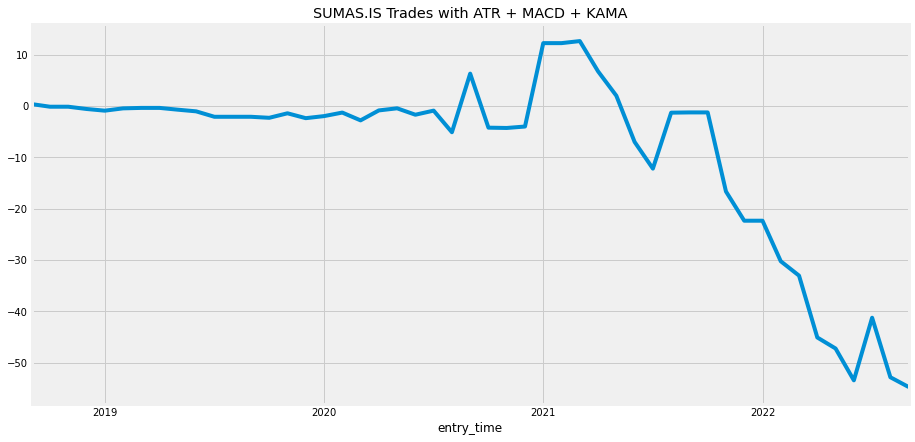

In [94]:
atr_macd_kama_test.set_index('entry_time').pnl.resample('M').sum().cumsum().plot(figsize=(14,7))
plt.title("%s Trades with ATR + MACD + KAMA" % SYMBOL)
plt.show()

In [95]:
data.head()

,Open,High,Low,Close,Vol_change,ma7,ma30,upper_band7,lower_band7,upper_band30,lower_band30,ema_fast,ema_slow,macd,signal,AOI,KAMA_FAST,KAMA_SLOW,ROC,RSI,STOCH_RSI,STOCH_RSI3,STOCH_RSI10,TSI_FAST,TSI_SLOW,WRI_FAST,ATR2,ATR,DC_HB,DC_LB,DC_MB,AI_D,AI_I,AI_U
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-04,4.95,4.95,4.43,4.89,-0.376762,4.911428,5.655334,5.092326,4.730531,7.652544,3.658123,4.960658,5.299056,-0.338398,-0.410104,-1.069088,6.461706,6.888461,4.935623,34.716503,0.970303,0.950858,0.949686,15.933916,-68.750229,-8.870978,0.52,0.309930,6.60,3.76,5.180,64.0,-60.0,4.0
2018-04-05,4.79,4.79,4.79,4.79,0.273011,4.881429,5.581666,5.063428,4.699429,7.536220,3.627113,4.934364,5.259376,-0.325012,-0.392302,-1.032794,6.448861,6.881026,2.132194,33.281929,0.891685,0.914753,0.961736,-61.673660,-67.369629,-16.935488,0.10,0.294935,5.99,3.76,4.875,60.0,-56.0,4.0
2018-04-06,4.75,4.75,4.75,4.75,-0.973346,4.860000,5.506667,5.065588,4.654411,7.407965,3.605369,4.905965,5.219823,-0.313859,-0.376041,-0.893618,6.440372,6.872518,1.063834,32.699856,0.859787,0.907258,0.947715,-78.746490,-66.227867,-25.000000,0.04,0.276725,5.95,3.76,4.855,56.0,-52.0,4.0
2018-04-09,4.90,4.90,4.53,4.66,42.977013,4.811429,5.428667,5.023223,4.599634,7.267427,3.589906,4.868084,5.176509,-0.308425,-0.362126,-0.853000,6.423725,6.865184,3.555552,31.370447,0.786932,0.846135,0.926408,-94.695717,-65.347839,-34.000015,0.37,0.283388,5.49,3.76,4.625,52.0,-48.0,4.0
2018-04-10,4.65,4.65,4.06,4.06,-0.357031,4.710000,5.330333,5.320027,4.099973,7.134356,3.526311,4.743651,5.090406,-0.346755,-0.358981,-0.872500,6.384160,6.858023,-13.247861,24.282782,0.398514,0.681744,0.866259,-99.668655,-65.327263,-94.000008,0.60,0.306003,5.49,3.76,4.625,100.0,-96.0,4.0


In [96]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import math
plt.style.use('fivethirtyeight')

In [97]:
data_sumas = data.filter(['Close'])
dataset = data_sumas.values
training_data_len = math.ceil(len(dataset) * .8)

# Scale the Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]

# Split the data itno x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [98]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

# Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [99]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Create the testing data set
# Create new array containing scaled values from index 1028 to 1359
test_data = scaled_data[training_data_len - 60: , :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len: , :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# convert data to numpy array
x_test = np.array(x_test)

# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean square error (RMSE)
rmse = np.sqrt( np.mean( predictions - y_test )**2 )

839/839 [==============================] - 16s 15ms/step - loss: 0.0042


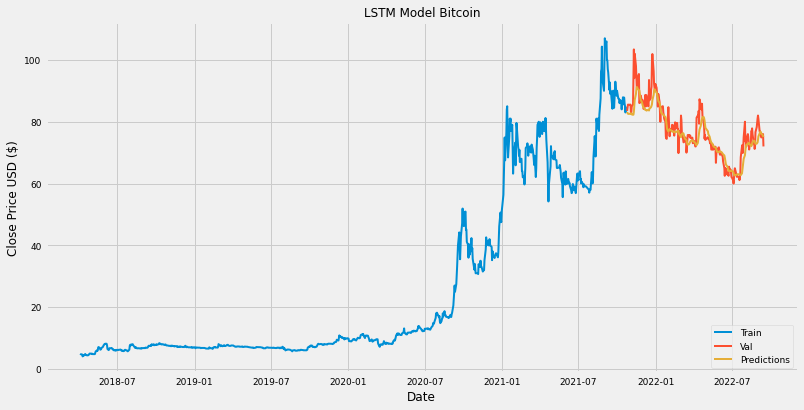

In [100]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(12,6))
plt.title('LSTM Model Bitcoin', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.tick_params(labelsize=9, width=0.2, length=1)

plt.plot(train['Close'], linewidth=2.0)
plt.plot(valid[['Close', 'Predictions']], linewidth=2.0)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right', fontsize=9)
plt.show()